# This code startet 9. marts

In [65]:
from KGS import *
from scipy.optimize import curve_fit

mpl.rcParams['font.size']        = 11

print(1e-34*1e-13)


1e-47


In [2]:
def plot_formalia(x_label, y_label, titel, fig_size = (5,4)):
    '''A function that takes care of setting up the plot, it requires axislabels and a title. Setting a figure size is optional.
    x_label is the label on the x-axis.
    y_label is the label on the y-axis.
    titel is the title for the plot.
    fig_size sets the size of the plot, it requires a touple of two numbers. If nothing is specified, it makes it nice for Ellen Schrivers 
    eyes (12,6).
    If a legend is wanted, you should put plt.legend() after what you want to plot.'''
    plt.figure(figsize = fig_size)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(titel)
    plt.grid(linestyle = '--')
   

In [3]:
def tre_punkt(array, weight = 1):
    '''A function that removes the background weighted after the amount of monitor'''
    return array[1] - (array[0] +array[2])*weight
    

In [4]:
def gauss(x, A, sigma, mu, b):
    '''a gaussian function used for fiting'''
    return A*np.exp(-0.5*(x - mu)**2/sigma**2) + b
    

In [5]:
def temporary_gauss(x, A, b):
    '''a gaussian function used for fiting'''
    return A*np.exp(-0.5*(x - .5)**2/(2.06256674e-02)**2) + b
    

In [6]:
def usikkerhed_tre_punkt(usikkerheder):
    ''' Regner usikkerheden på et gennemsnit, som er vægtet ligeligt. Skal have et numpy array, som er 3 elementer langt, hvor gennemsnittet af det 
    første og det sidste punkt trækkes fra det midterste.'''
    return np.sqrt(np.sqrt(usikkerheder[1])**2 + np.sqrt(usikkerheder[0])**2/4 + np.sqrt(usikkerheder[2])**2/4)
    

In [7]:
#Endnu en sum, den magnetiske form faktor f(Q) = Ae^(-a(Q/4\pi)^2) + Be^(-b(Q/4\pi)^2) + Ce^(-c(Q/4\pi)^2) + D
#Tabelverdier er fra https://www.ill.eu/sites/ccsl/ffacts/ffactnode4.html, Q = 2
#     f(Q)           = .935 * Nd3+                                                                                                                                                           Cu2+
magnetic_form_factor = .935 * (.054 * np.exp(-25.0293 * (1 / (2 * np.pi)**2)) + .3101 * np.exp(-12.1020 * (1 / (2 * np.pi)**2)) + .6575 * np.exp(-4.7223 * (1 / (2 * np.pi)**2)) - .0216) + .0232 * np.exp(-34.9686 * (1 / (2 * np.pi)**2)) + .4023 * np.exp(-11.5640 * (1 / (2 * np.pi)**2)) + .5882 * np.exp(-3.8428 * (1 / (2 * np.pi)**2)) - .0137 


In [8]:
def structure_factor_elements_for_sum(f_j, x_j, y_j, z_j, h, k, l):
    '''A function that calculates an element in the sum 
    F_hkl = Sum_unit-cell f_j*e^(-i2pi(hx_j + ky_j + lz_j))
    For the sc sample hkl is h = 1.9999, k = 0.0000, l = 0.0000
    For the ag sample hkl is h = 1.9998, k = 0.0000, l = 0.0000'''
    return f_j * np.exp(-2 * np.pi * (h * x_j + k * y_j + l * z_j) * 1j)


In [9]:
# I define the places of the atoms in the unit cell. Det gør jeg for at finde F_N(Q) senere
# Jeg finder b_j scattering længderne på 
# https://www.ncnr.nist.gov/resources/n-lengths/
# Jeg omregner så til f_j med f_j = 2 pi h_bar^2 b_j / m, se Simon s. 145
#Ikke aligevel, fordi Coh b i tabellen er f_j

f_Cu = 7.718 * 10**(-15) #m
f_O = 5.803 * 10**(-15)
f_Ce = 4.84 * 10**(-15)
f_Nd = 7.69 * 10**(-15)

#Nu definerer jeg mine atomer som de ligger, atomernes postioner finder jeg i 
#.cif filen jeg har fået af Kristine. Jeg finder ækvivalente punkter på 
# hjemmesiden https://www.cryst.ehu.es/cgi-bin/cryst/programs/nph-wp-list, for 
# 139

Nd_Ce = np.array([[0, 0, 0.353], [0, 0, -0.353], [.5, .5, .5 + 0.353], [.5, .5, .5 - 0.353]]) # Jeg er ikke sikker på at jeg forstår (0,0,-z)
Cu = np.array([[0.00000, 0.00000, 0.00000], [.5,.5,.5]]) # Det stemmer med hvad jeg forventede 
O = np.array([[0, .5, 0], [.5, 0, 0], [.5, 1, .5], [1, .5, .5], [0, .5, 0.25], [.5, 0, .25], [.5, 1, .75], [1, .5, .75]])


In [10]:
# Her regner jeg m/M
m_neutron = 1.009 #u

m_Cu = 63.546 #u * 1.6605402E-27 #kg 
m_O = 15.999 #u * 1.6605402E-27 #kg 
m_Ce = 140.116 #u * 1.6605402E-27 #kg 
m_Nd = 144.242 #u * 1.6605402E-27 #kg 

M = 2 * m_Cu + 8 * m_O + 2 * 1.85 * m_Nd + 2 * 0.15 * m_Ce # u

m_div_M = m_neutron / M

print(m_div_M)


0.001214471298155472


In [11]:
def hbar_Q_i_anden_over_2_m (Q_h, Q_k, a = 3.9422):
    '''This equation is for calculating the factor (h_bar Q)^2 / (2m) when normalizing to the phonon. It knows h_bar in meV s, the mass of the neutron,
    and assumes the latticeparameter of NCCO in Å. The output is in meV. 
    '''
    h_bar_meV = 6.582 * 10**(-13) #meV s
    h_bar_SI = 1.055*10**(-34) #J s
    m_neutron = 1.674927485 * 10**(-27) #kg (skal være i kg fordi så går J ud) 
    
    return h_bar_meV * h_bar_SI * (np.sqrt((2 * np.pi * Q_h / a)**2 + (2 * np.pi * Q_k / a))* 10**10)**2  / (2 * m_neutron) # meV, de 10^10 er konvertering mellem Å^-1 og m^-1 igen så J går ud
    

In [12]:
def gauss_for_double_gauss(x, A, mu, sigma):
    return A*np.exp(-(x - mu)**2/(2*sigma**2))

def combined(x, A, mu, sigma, A2, mu2, sigma_2, lin_offset):
    return gauss_for_double_gauss(x, A, mu, sigma) + gauss_for_double_gauss(x, A2, mu2, sigma_2) + lin_offset 
#Først laver jeg to typer funktioner, og siden lægger jeg dem sammen. 


def integral(dw, dq, Q, F, E = 3):
    '''A function to normalize to the phonon. This function takes care of the right side of eq. 20 in normalization paper.
    It looks like 1 / (dw / dq * E) * (h_bar * Q)**2 / (2*M) * np.abs(F)**2, in theory there is also a 
    factor NR_0k_f at the end, but as the output of this function is to normalize to this factor the NR_0k_f disappears,
    as desired. Omregner til SI enheder fra Å og meV og tilbage. The function also calculates the mass of the unit cell for NCCO 
    Remember to convert Q to reciprocal Ångstrøm, og F_N(G)'''
    m_Cu = 63.546 #u * 1.6605402E-27 #kg 
    m_O = 15.999 #u * 1.6605402E-27 #kg 
    m_Ce = 140.116 #u * 1.6605402E-27 #kg 
    m_Nd = 144.242 #u * 1.6605402E-27 #kg 

    M = 2 * m_Cu + 8 * m_O + 2 * 1.85 * m_Nd + 2 * 0.15 * m_Ce

    #TJEK ENHEDER FOR DET HELE, skal kg omregnes, når nu jeg har omregnet energier til meV

    a = 3.9422 # Å det er latticparameteren
    h_bar = 6.582 * 10**(-13) #meV s   1.055*10**(-34) #Js
    return 1 / ((E / h_bar) / dq * E) * (h_bar * np.sqrt((Q * 2 * np.pi / a)**2 + (2 * 2 * np.pi / a)**2))**2 / (2*M) * np.abs(F)**2 * 10**(-8) # Nu burden den være i meV/b  #Den er i SI enheder, det er der det går galt, regn tilbage til de relevante enheder, og så burde det være fint
    #Det ovenstående ganget med Nk_fR_0 skulle gerne få enheder I/m^3 Nk_fR_0 har enheder I/m det ovenstående må ha enheder m^-2. Jeg regner dermed til Å^-2 ved at gange med 10^-20

# SC sample
### q-scans

In [13]:
#Normalisation to the phonon
F_sc = 0
#Jeg regner hvert atom for sig, rækkefølge Nd, Ce, Cu, O 
for i in range(len(Nd_Ce)):
    F_sc += 0.935 * structure_factor_elements_for_sum(f_Nd, Nd_Ce[i,0], Nd_Ce[i,1], Nd_Ce[i,2], 1.9999, 0, 0.0000)
print(np.abs(F_sc)**2)
for i in range(len(Nd_Ce)):
    F_sc += 0.065 * structure_factor_elements_for_sum(f_Ce, Nd_Ce[i,0], Nd_Ce[i,1], Nd_Ce[i,2], 1.9999, 0, 0.0000)
print(np.abs(F_sc)**2)
for i in range(len(Cu)):
    F_sc += structure_factor_elements_for_sum(f_Cu, Cu[i,0], Cu[i,1], Cu[i,2], 1.9999, 0, 0.0000)
print(np.abs(F_sc)**2)
for i in range(len(O)):
    F_sc += structure_factor_elements_for_sum(f_O, O[i,0], O[i,1], O[i,2], 1.9999, 0, 0.0000)

print('F_N(Q) =', np.abs(F_sc), 'm') 
F_sc_ianden = np.abs(F_sc)**2 * 10**(28)
print('abs(F_N(Q))^2 =', F_sc_ianden, 'barn')



8.27172091950347e-28
9.011403387652529e-28
2.0661569740196203e-27
F_N(Q) = 9.187899801040876e-14 m
abs(F_N(Q))^2 = 84.41750275396697 barn


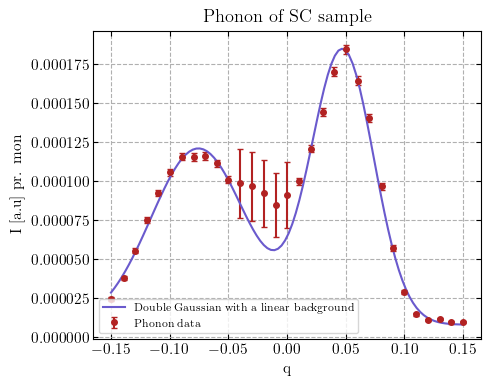

In [14]:
# Her finder jeg domega/dq
# Jeg identificerer peaks i min phonon scanning
sc_phonon = np.genfromtxt('./Data/038367', skip_header = 63)

err_sc_phonon = np.sqrt(sc_phonon[:,8])/20e+6
err_sc_phonon[11:16] = err_sc_phonon[11:16]*10

plot_formalia('q', 'I [a.u] pr. mon', 'Phonon of SC sample')
plt.errorbar(sc_phonon[:,2], sc_phonon[:,8]/20e+6, capsize = 2, yerr = err_sc_phonon, fmt = 'o', label = 'Phonon data', color = 'firebrick')

guess = [ 1.11909676e-04, -7.53678518e-02,  4.00355575e-02,  1.75494263e-04,  4.73632460e-02,  2.64055694e-02, 0.000009]
#             A               Mu                Sigma            A2               Mu2             sigma2      lin_offset
par, cov = curve_fit(combined, sc_phonon[:,2], ydata = sc_phonon[:,8]/20e+6, sigma = err_sc_phonon, absolute_sigma=True, p0 = (guess))

x = np.linspace(-.15, .15, 100)
plt.plot(x, combined(x, *par), label = 'Double Gaussian with a linear background', color = 'slateblue')
plt.legend(fontsize = 8)

domega_sc = 3.0005 #meV Jeg er uklar på hvorfor jeg ikke skal dividere med h_bar, Henrik kigger på det. 
dq_sc = par[4]

domega_dq_sc = domega_sc / dq_sc # meV/r.l.u. (r.l.u. er reciprocal lattice units) 


In [15]:
#Here I calculate the (hbarQ)^2/2m for the superconducting sample (Q_h, Q_k, a = 3.9422)

hbar_Q_i_anden_over_2_m_sc = hbar_Q_i_anden_over_2_m (1.9999, dq_sc)
print(hbar_Q_i_anden_over_2_m_sc)


21.21790048810101


In [16]:
# Nu regner jeg n(q)/h_bar omega
# Vi har målt phononen ved 100K, 3.0005 meV

energy_phonon_sc = 3.0005 #meV
phonon_k_B_T = 0.08617 * 100 #meV K / K

#h_bar_meV = 6.582 * 10**(-13) #meV s

n_q_div_h_bar_omega_sc = 1 / ((1 - np.exp(- energy_phonon_sc / phonon_k_B_T) )* energy_phonon_sc)


In [17]:
# Nu ka jeg finde integralet over intensiteten 
from scipy import integrate
doubble_gauss_lin_offset_sc = lambda x: 1.13049423e-04 *np.exp(-(x + 7.54701598e-02)**2/(2*(4.03735451e-02)**2)) + 1.75838124e-04 *np.exp(-(x -  4.74259983e-02)**2/(2*(2.67407896e-02)**2)) + 7.77883880e-06 #Det er en dobbelt gaus med de fittede parametre 

integral_sc_positive = integrate.quad(doubble_gauss_lin_offset_sc, -.02, 0.15)
integral_sc_negative = integrate.quad(doubble_gauss_lin_offset_sc, -0.15, -.02)


integral_sc = (integral_sc_negative[0] + integral_sc_positive[0])/2


In [18]:
# Nu ka jeg finde Nk_fR_0
Nk_fR_0_sc = integral_sc / (1 / domega_dq_sc * n_q_div_h_bar_omega_sc * hbar_Q_i_anden_over_2_m_sc * m_div_M * F_sc_ianden)

print(Nk_fR_0_sc)


0.0003231787473755835


In [19]:
#Now I can convert to either S or X''
S_of_Q_and_E_sc = 13.77/Nk_fR_0_sc #meV 

sc_phonon_normalisation = 1 / (10**3 * np.pi / 2 * 13.77 / (magnetic_form_factor**2 * Nk_fR_0_sc)) #mu_B eV^-1  10^3 converts to eV^-1

print(1/sc_phonon_normalisation)


26304977.97721902


In [20]:
#27K
#Der er 2 filer for hhv. 2meV og 8meV, fordi vi gerne ville have ekstra data her, da det er de vigtige q-scans
sc_q_27K_2mev = np.genfromtxt('./Data/038370', skip_header = 63)
sc_q_27K_4mev = np.genfromtxt('./Data/038371', skip_header = 63)
sc_q_27K_5mev = np.genfromtxt('./Data/038369', skip_header = 63)
sc_q_27K_6mev = np.genfromtxt('./Data/038372', skip_header = 63) 
sc_q_27K_8mev = np.genfromtxt('./Data/038373', skip_header = 63)

sc_q_27K_2mev_2 = np.genfromtxt('./Data/038460', skip_header = 63)
sc_q_27K_8mev_2 = np.genfromtxt('./Data/038459', skip_header = 63)

sc_q_27K_2mev[:,8] = sc_q_27K_2mev[:,8] + sc_q_27K_2mev_2[:,8]   
sc_q_27K_8mev[:,8] = sc_q_27K_8mev[:,8] + sc_q_27K_8mev_2[:,8]

#2K 
#Vi fylte ny nitrogen på halvvejs igennem 2_mev, derfor skal to filer stiches sammen
#Der er 2 filer for hhv. 2meV og 8meV, fordi vi gerne ville have ekstra data her, da det er de vigtige q-scans
sc_q_2K_2mev = np.genfromtxt('./Data/038394', skip_header = 63)
sc_q_2K_8mev = np.genfromtxt('./Data/038393', skip_header = 63)
sc_q_2K_8mev_2 = np.genfromtxt('./Data/038415', skip_header = 63)
sc_q_2K_2mev_2_1 = np.genfromtxt('./Data/038416', skip_header = 63)
sc_q_2K_2mev_2_2 = np.genfromtxt('./Data/038420', skip_header = 63)
sc_q_2K_2mev_2 = np.append(sc_q_2K_2mev_2_1, sc_q_2K_2mev_2_2, axis = 0)

sc_q_2K_2mev[:,8] = sc_q_2K_2mev[:,8] + sc_q_2K_2mev_2[:,8]   
sc_q_2K_8mev[:,8] = sc_q_2K_8mev[:,8] + sc_q_2K_8mev_2[:,8] 


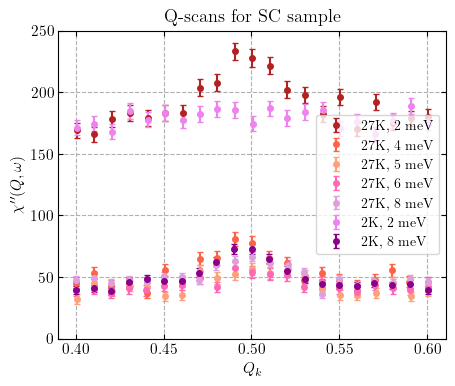

In [21]:
plot_formalia('$Q_k$', '$\chi\'\'(Q,\omega)$', 'Q-scans for SC sample')
plt.ylim(0, 250)
#27K
plt.errorbar(sc_q_27K_2mev[:,2], sc_q_27K_2mev[:,8]/120000000/sc_phonon_normalisation, capsize = 2, yerr = np.sqrt(sc_q_27K_2mev[:,8])/120000000/sc_phonon_normalisation, fmt = 'o', label = '27K, 2 meV', color = 'firebrick')
plt.errorbar(sc_q_27K_4mev[:,2], sc_q_27K_4mev[:,8]/60000000/sc_phonon_normalisation, capsize = 2, yerr = np.sqrt(sc_q_27K_4mev[:,8])/60000000/sc_phonon_normalisation, fmt = 'o', label = '27K, 4 meV', color = 'tomato')
plt.errorbar(sc_q_27K_5mev[:,2], sc_q_27K_5mev[:,8]/60000000/sc_phonon_normalisation, capsize = 2, yerr = np.sqrt(sc_q_27K_5mev[:,8])/60000000/sc_phonon_normalisation, fmt = 'o', label = '27K, 5 meV', color = 'lightsalmon')
plt.errorbar(sc_q_27K_6mev[:,2], sc_q_27K_6mev[:,8]/60000000/sc_phonon_normalisation, capsize = 2, yerr = np.sqrt(sc_q_27K_6mev[:,8])/60000000/sc_phonon_normalisation, fmt = 'o', label = '27K, 6 meV', color = 'hotpink')
plt.errorbar(sc_q_27K_8mev[:,2], sc_q_27K_8mev[:,8]/120000000/sc_phonon_normalisation, capsize = 2, yerr = np.sqrt(sc_q_27K_8mev[:,8])/120000000/sc_phonon_normalisation, fmt = 'o', label = '27K, 8 meV', color = 'plum')
#2K
plt.errorbar(sc_q_2K_2mev[:,2], sc_q_2K_2mev[:,8]/120000000/sc_phonon_normalisation, capsize = 2, yerr = np.sqrt(sc_q_2K_2mev[:,8])/120000000/sc_phonon_normalisation, fmt = 'o', label = '2K, 2 meV', color = 'violet')
plt.errorbar(sc_q_2K_8mev[:,2], sc_q_2K_8mev[:,8]/120000000/sc_phonon_normalisation, capsize = 2, yerr = np.sqrt(sc_q_2K_8mev[:,8])/120000000/sc_phonon_normalisation, fmt = 'o', label = '2K, 8 meV', color = 'darkmagenta')

plt.legend(fontsize = 10)


In [22]:
#27K
#2meV
sc_startguess_27K_2mev = [200, .025, .5, 300]
sc_par_q_27K_2mev, sc_cov_q_27K_2mev = curve_fit(gauss, sc_q_27K_2mev[:,2], sc_q_27K_2mev[:,8], sigma = np.sqrt(sc_q_27K_2mev[:,8]), p0 = sc_startguess_27K_2mev)

#4meV
sc_startguess_27K_4mev = [200, .025, .5, 300]
sc_par_q_27K_4mev, sc_cov_q_27K_4mev = curve_fit(gauss, sc_q_27K_4mev[:,2], sc_q_27K_4mev[:,8], sigma = np.sqrt(sc_q_27K_4mev[:,8]), p0 = sc_startguess_27K_4mev)

#5meV
sc_startguess_27K_5mev = [200, .025, .5, 300]
sc_par_q_27K_5mev, sc_cov_q_27K_5mev = curve_fit(gauss, sc_q_27K_5mev[:,2], sc_q_27K_5mev[:,8], sigma = np.sqrt(sc_q_27K_5mev[:,8]), p0 = sc_startguess_27K_5mev)

#6meV
sc_startguess_27K_6mev = [200, .025, .5, 300]
sc_par_q_27K_6mev, sc_cov_q_27K_6mev = curve_fit(gauss, sc_q_27K_6mev[:,2], sc_q_27K_6mev[:,8], sigma = np.sqrt(sc_q_27K_6mev[:,8]), p0 = sc_startguess_27K_6mev)

#8meV
sc_startguess_27K_8mev = [200, .025, .5, 300]
sc_par_q_27K_8mev, sc_cov_q_27K_8mev = curve_fit(gauss, sc_q_27K_8mev[:,2], sc_q_27K_8mev[:,8], sigma = np.sqrt(sc_q_27K_8mev[:,8]), p0 = sc_startguess_27K_8mev)

width_sc = (sc_par_q_27K_2mev[1] + sc_par_q_27K_4mev[1] + sc_startguess_27K_5mev[1] + sc_startguess_27K_6mev[1] + sc_startguess_27K_8mev[1])/5


x = np.linspace(.4, .6, 100)

plot_formalia('Qk', 'counts', 'data', fig_size = (6,6))
plt.errorbar(sc_q_27K_8mev[:,2], sc_q_27K_8mev[:,8], yerr = np.sqrt(sc_q_27K_8mev[:,8]), fmt = 'o', label = '27K 8meV')
plt.plot(x, gauss(x, *sc_par_q_27K_8mev))
plt.legend()


In [23]:
print('Intensities for the peaks found by fitting gaussians to the data from the SC-sample')
print('intensitet/monitor and phonon for the q-scans at 27K 2meV:', sc_par_q_27K_2mev[0]/120000000/sc_phonon_normalisation, '\pm', np.sqrt(sc_cov_q_27K_2mev[0,0])/120000000/sc_phonon_normalisation) 
print('intensitet/monitor and phonon for the q-scans at 27K 4meV:', sc_par_q_27K_4mev[0]/60000000/sc_phonon_normalisation, '\pm', np.sqrt(sc_cov_q_27K_4mev[0,0])/60000000/sc_phonon_normalisation) 
print('intensitet/monitor and phonon for the q-scans at 27K 5meV:', sc_par_q_27K_5mev[0]/60000000/sc_phonon_normalisation, '\pm', np.sqrt(sc_cov_q_27K_5mev[0,0])/60000000/sc_phonon_normalisation) 
print('intensitet/monitor and phonon for the q-scans at 27K 6meV:', sc_par_q_27K_6mev[0]/60000000/sc_phonon_normalisation, '\pm', np.sqrt(sc_cov_q_27K_6mev[0,0])/60000000/sc_phonon_normalisation)
print('intensitet/monitor and phonon for the q-scans at 27K 8meV:', sc_par_q_27K_8mev[0]/120000000/sc_phonon_normalisation, '\pm', np.sqrt(sc_cov_q_27K_8mev[0,0])/120000000/sc_phonon_normalisation)

sc_q_27K_intensity = np.array([sc_par_q_27K_2mev[0]/120000000,
                               sc_par_q_27K_4mev[0]/60000000,
                               sc_par_q_27K_5mev[0]/60000000,
                               sc_par_q_27K_6mev[0]/60000000,
                               sc_par_q_27K_8mev[0]/120000000])/sc_phonon_normalisation * width_sc
sc_err_q_27K_intensity = np.array([np.sqrt(sc_cov_q_27K_2mev[0,0])/120000000,
                                   np.sqrt(sc_cov_q_27K_4mev[0,0])/60000000,
                                   np.sqrt(sc_cov_q_27K_5mev[0,0])/60000000,
                                   np.sqrt(sc_cov_q_27K_6mev[0,0])/60000000,
                                   np.sqrt(sc_cov_q_27K_8mev[0,0])/120000000])/sc_phonon_normalisation *width_sc
sc_mevs_q_27K = np.array([2, 4, 5, 6, 8])


Intensities for the peaks found by fitting gaussians to the data from the SC-sample
intensitet/monitor and phonon for the q-scans at 27K 2meV: 51.34717173850745 \pm 5.319190725931
intensitet/monitor and phonon for the q-scans at 27K 4meV: 32.013394960322636 \pm 4.403935009287223
intensitet/monitor and phonon for the q-scans at 27K 5meV: 19.76646253136219 \pm 3.6643343525573964
intensitet/monitor and phonon for the q-scans at 27K 6meV: 13.930117415782414 \pm 2.2686709737675717
intensitet/monitor and phonon for the q-scans at 27K 8meV: 20.9093761810382 \pm 3.353716518962312


### Three point scans

In [24]:
#27K
#We didn't take an extra point measurement of the 2meV 
sc_tre_27K_2mev = np.genfromtxt('./Data/038375', skip_header = 63)

#We set the program to run and then decided we wanted a point more, so I add the new counts to the previous 
#data
sc_tre_27K_4mev = np.genfromtxt('./Data/038376', skip_header = 63)
sc_tre_27K_4mev_1 = np.genfromtxt('./Data/038377', skip_header = 63)
sc_tre_27K_4mev_2 = np.genfromtxt('./Data/038392', skip_header = 63)
sc_tre_27K_4mev[1,8] = sc_tre_27K_4mev[1,8] + sc_tre_27K_4mev_1[8] + sc_tre_27K_4mev_2[8] 

sc_tre_27K_2_5mev = np.genfromtxt('./Data/038457', skip_header = 63)
sc_tre_27K_2_5mev_1 = np.genfromtxt('./Data/038458', skip_header = 63)
sc_tre_27K_2_5mev[1,8] = sc_tre_27K_2_5mev[1,8] + sc_tre_27K_2_5mev_1[8]

sc_tre_27K_3mev = np.genfromtxt('./Data/038388', skip_header = 63)
sc_tre_27K_3mev_1 = np.genfromtxt('./Data/038389', skip_header = 63)
sc_tre_27K_3mev[1,8] = sc_tre_27K_3mev[1,8] + sc_tre_27K_3mev_1[8]

sc_tre_27K_5mev = np.genfromtxt('./Data/038378', skip_header = 63)
sc_tre_27K_5mev_1 = np.genfromtxt('./Data/038379', skip_header = 63)
sc_tre_27K_5mev[1,8] = sc_tre_27K_5mev[1,8] + sc_tre_27K_5mev_1[8]

sc_tre_27K_6mev = np.genfromtxt('./Data/038380', skip_header = 63)
sc_tre_27K_6mev_1 = np.genfromtxt('./Data/038381', skip_header = 63)
sc_tre_27K_6mev[1,8] = sc_tre_27K_6mev[1,8] + sc_tre_27K_6mev_1[8]

sc_tre_27K_7mev = np.genfromtxt('./Data/038451', skip_header = 63)
sc_tre_27K_7mev_1 = np.genfromtxt('./Data/038452', skip_header = 63)
sc_tre_27K_7mev[1,8] = sc_tre_27K_7mev[1,8] + sc_tre_27K_7mev_1[8]

sc_tre_27K_8mev = np.genfromtxt('./Data/038382', skip_header = 63)
sc_tre_27K_8mev_1 = np.genfromtxt('./Data/038383', skip_header = 63)
sc_tre_27K_8mev[1,8] = sc_tre_27K_8mev[1,8] + sc_tre_27K_8mev_1[8]

sc_tre_27K_9mev = np.genfromtxt('./Data/038453', skip_header = 63)
sc_tre_27K_9mev_1 = np.genfromtxt('./Data/038454', skip_header = 63)
sc_tre_27K_9mev[1,8] = sc_tre_27K_9mev[1,8] + sc_tre_27K_9mev_1[8]

sc_tre_27K_10mev = np.genfromtxt('./Data/038384', skip_header = 63)
sc_tre_27K_10mev_1 = np.genfromtxt('./Data/038385', skip_header = 63)
sc_tre_27K_10mev[1,8] = sc_tre_27K_10mev[1,8] + sc_tre_27K_10mev_1[8]

sc_tre_27K_11mev = np.genfromtxt('./Data/038455', skip_header = 63)
sc_tre_27K_11mev_1 = np.genfromtxt('./Data/038456', skip_header = 63)
sc_tre_27K_11mev[1,8] = sc_tre_27K_11mev[1,8] + sc_tre_27K_11mev_1[8]

sc_tre_27K_12mev = np.genfromtxt('./Data/038390', skip_header = 63)
sc_tre_27K_12mev_1 = np.genfromtxt('./Data/038391', skip_header = 63)
sc_tre_27K_12mev[1,8] = sc_tre_27K_12mev[1,8] + sc_tre_27K_12mev_1[8]

sc_tre_27K_13mev = np.genfromtxt('./Data/038386', skip_header = 63)
sc_tre_27K_13mev_1 = np.genfromtxt('./Data/038387', skip_header = 63)
sc_tre_27K_13mev[1,8] = sc_tre_27K_13mev[1,8] + sc_tre_27K_13mev_1[8]


In [25]:
sc_tre_27K_2mev_background = (sc_tre_27K_2mev[0,8] + sc_tre_27K_2mev[2,8])/2
sc_tre_27K_2mev_peak = (sc_tre_27K_2mev[1,8] - sc_tre_27K_2mev_background)/300000000
sc_tre_27K_2_5mev_peak = tre_punkt(sc_tre_27K_2_5mev[:,8],)/240000000
sc_tre_27K_3mev_peak = tre_punkt(sc_tre_27K_3mev[:,8])/240000000
sc_tre_27K_4mev_peak = tre_punkt(sc_tre_27K_4mev[:,8],)/240000000
sc_tre_27K_5mev_peak = tre_punkt(sc_tre_27K_5mev[:,8])/240000000
sc_tre_27K_6mev_peak = tre_punkt(sc_tre_27K_6mev[:,8])/240000000
sc_tre_27K_7mev_peak = tre_punkt(sc_tre_27K_7mev[:,8])/240000000
sc_tre_27K_8mev_peak = tre_punkt(sc_tre_27K_8mev[:,8])/240000000
sc_tre_27K_9mev_peak = tre_punkt(sc_tre_27K_9mev[:,8])/240000000
sc_tre_27K_10mev_peak = tre_punkt(sc_tre_27K_10mev[:,8])/240000000
sc_tre_27K_11mev_peak = tre_punkt(sc_tre_27K_11mev[:,8])/240000000
sc_tre_27K_12mev_peak = tre_punkt(sc_tre_27K_12mev[:,8])/240000000
sc_tre_27K_13mev_peak = tre_punkt(sc_tre_27K_13mev[:,8])/240000000


sc_tre_27K_intensity = np.array([sc_tre_27K_2mev_peak, 
                                       sc_tre_27K_2_5mev_peak, 
                                       sc_tre_27K_3mev_peak, 
                                       sc_tre_27K_4mev_peak, 
                                       sc_tre_27K_5mev_peak,
                                       sc_tre_27K_6mev_peak, 
                                       sc_tre_27K_7mev_peak, 
                                       sc_tre_27K_8mev_peak, 
                                       sc_tre_27K_9mev_peak, 
                                       sc_tre_27K_10mev_peak, 
                                       sc_tre_27K_11mev_peak, 
                                       sc_tre_27K_12mev_peak, 
                                       sc_tre_27K_13mev_peak])/sc_phonon_normalisation * width_sc
sc_err_tre_27K_intensity = np.array([usikkerhed_tre_punkt(sc_tre_27K_2mev[:,8])/300000000,
                                 usikkerhed_tre_punkt(sc_tre_27K_2_5mev[:,8])/240000000,  
                                 usikkerhed_tre_punkt(sc_tre_27K_3mev[:,8])/240000000, #Jeg er ikke sikker på hvorfor men, jeg havde tidligere skrevet 180000000 monitor  
                                 usikkerhed_tre_punkt(sc_tre_27K_4mev[:,8])/240000000, 
                                 usikkerhed_tre_punkt(sc_tre_27K_5mev[:,8])/240000000,
                                 usikkerhed_tre_punkt(sc_tre_27K_6mev[:,8])/240000000,
                                 usikkerhed_tre_punkt(sc_tre_27K_7mev[:,8])/240000000, 
                                 usikkerhed_tre_punkt(sc_tre_27K_8mev[:,8])/240000000, 
                                 usikkerhed_tre_punkt(sc_tre_27K_9mev[:,8])/240000000, 
                                 usikkerhed_tre_punkt(sc_tre_27K_10mev[:,8])/240000000,
                                 usikkerhed_tre_punkt(sc_tre_27K_11mev[:,8])/240000000, 
                                 usikkerhed_tre_punkt(sc_tre_27K_12mev[:,8])/240000000, 
                                 usikkerhed_tre_punkt(sc_tre_27K_13mev[:,8])/240000000]) /sc_phonon_normalisation * width_sc
sc_tre_27K_mevs = np.array([2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])



In [26]:
#2K
sc_tre_2K_2mev = np.genfromtxt('./Data/038395', skip_header = 63)
sc_tre_2K_2mev_1 = np.genfromtxt('./Data/038396', skip_header = 63)
sc_tre_2K_2mev[1,8] = sc_tre_2K_2mev[1,8] + sc_tre_2K_2mev_1[8]

sc_tre_2K_2_5mev = np.genfromtxt('./Data/038425', skip_header = 63)
sc_tre_2K_2_5mev_1 = np.genfromtxt('./Data/038426', skip_header = 63)
sc_tre_2K_2_5mev[1,8] = sc_tre_2K_2_5mev[1,8] + sc_tre_2K_2_5mev_1[8]

sc_tre_2K_3mev = np.genfromtxt('./Data/038397', skip_header = 63)
sc_tre_2K_3mev_1 = np.genfromtxt('./Data/038398', skip_header = 63)
sc_tre_2K_3mev[1,8] = sc_tre_2K_3mev[1,8] + sc_tre_2K_3mev_1[8]

sc_tre_2K_4mev = np.genfromtxt('./Data/038399', skip_header = 63)
sc_tre_2K_4mev_1 = np.genfromtxt('./Data/038400', skip_header = 63)
sc_tre_2K_4mev[1,8] = sc_tre_2K_4mev[1,8] + sc_tre_2K_4mev_1[8]

sc_tre_2K_5mev = np.genfromtxt('./Data/038401', skip_header = 63)
sc_tre_2K_5mev_1 = np.genfromtxt('./Data/038402', skip_header = 63)
sc_tre_2K_5mev[1,8] = sc_tre_2K_5mev[1,8] + sc_tre_2K_5mev_1[8]

sc_tre_2K_6mev = np.genfromtxt('./Data/038403', skip_header = 63)
sc_tre_2K_6mev_1 = np.genfromtxt('./Data/038404', skip_header = 63)
sc_tre_2K_6mev[1,8] = sc_tre_2K_6mev[1,8] + sc_tre_2K_6mev_1[8]

sc_tre_2K_7mev = np.genfromtxt('./Data/038421', skip_header = 63)
sc_tre_2K_7mev_1 = np.genfromtxt('./Data/038422', skip_header = 63)
sc_tre_2K_7mev[1,8] = sc_tre_2K_7mev[1,8] + sc_tre_2K_7mev_1[8]

sc_tre_2K_8mev = np.genfromtxt('./Data/038405', skip_header = 63)
sc_tre_2K_8mev_1 = np.genfromtxt('./Data/038406', skip_header = 63)
sc_tre_2K_8mev[1,8] = sc_tre_2K_8mev[1,8] + sc_tre_2K_8mev_1[8]

sc_tre_2K_9mev = np.genfromtxt('./Data/038423', skip_header = 63)
sc_tre_2K_9mev_1 = np.genfromtxt('./Data/038424', skip_header = 63)
sc_tre_2K_9mev[1,8] = sc_tre_2K_9mev[1,8] + sc_tre_2K_9mev_1[8]

sc_tre_2K_10mev = np.genfromtxt('./Data/038407', skip_header = 63)
sc_tre_2K_10mev_1 = np.genfromtxt('./Data/038408', skip_header = 63)
sc_tre_2K_10mev[1,8] = sc_tre_2K_10mev[1,8] + sc_tre_2K_10mev_1[8]

sc_tre_2K_11mev = np.genfromtxt('./Data/038409', skip_header = 63)
sc_tre_2K_11mev_1 = np.genfromtxt('./Data/038410', skip_header = 63)
sc_tre_2K_11mev[1,8] = sc_tre_2K_11mev[1,8] + sc_tre_2K_11mev_1[8]

sc_tre_2K_12mev = np.genfromtxt('./Data/038411', skip_header = 63)
sc_tre_2K_12mev_1 = np.genfromtxt('./Data/038412', skip_header = 63)
sc_tre_2K_12mev[1,8] = sc_tre_2K_12mev[1,8] + sc_tre_2K_12mev_1[8]

sc_tre_2K_13mev = np.genfromtxt('./Data/038413', skip_header = 63)
sc_tre_2K_13mev_1 = np.genfromtxt('./Data/038414', skip_header = 63)
sc_tre_2K_13mev[1,8] = sc_tre_2K_13mev[1,8] + sc_tre_2K_13mev_1[8]


In [27]:
#Subtracting the average of the background
sc_tre_2K_2mev_peak = tre_punkt(sc_tre_2K_2mev[:,8])/240000000
sc_tre_2K_2_5mev_peak = tre_punkt(sc_tre_2K_2_5mev[:,8])/240000000
sc_tre_2K_3mev_peak = tre_punkt(sc_tre_2K_3mev[:,8])/240000000
sc_tre_2K_4mev_peak = tre_punkt(sc_tre_2K_4mev[:,8],)/240000000
sc_tre_2K_5mev_peak = tre_punkt(sc_tre_2K_5mev[:,8])/240000000
sc_tre_2K_6mev_peak = tre_punkt(sc_tre_2K_6mev[:,8])/240000000
sc_tre_2K_7mev_peak = tre_punkt(sc_tre_2K_7mev[:,8])/240000000
sc_tre_2K_8mev_peak = tre_punkt(sc_tre_2K_8mev[:,8])/240000000
sc_tre_2K_9mev_peak = tre_punkt(sc_tre_2K_9mev[:,8])/240000000
sc_tre_2K_10mev_peak = tre_punkt(sc_tre_2K_10mev[:,8])/240000000
sc_tre_2K_11mev_peak = tre_punkt(sc_tre_2K_11mev[:,8])/240000000
sc_tre_2K_12mev_peak = tre_punkt(sc_tre_2K_12mev[:,8])/240000000
sc_tre_2K_13mev_peak = tre_punkt(sc_tre_2K_13mev[:,8])/240000000

#Combining into a plottable array
sc_tre_2K_intensity = np.array([sc_tre_2K_2mev_peak, 
                                sc_tre_2K_2_5mev_peak, 
                                sc_tre_2K_3mev_peak, 
                                sc_tre_2K_4mev_peak, 
                                sc_tre_2K_5mev_peak,
                                sc_tre_2K_6mev_peak, 
                                sc_tre_2K_7mev_peak, 
                                sc_tre_2K_8mev_peak, 
                                sc_tre_2K_9mev_peak, 
                                sc_tre_2K_10mev_peak, 
                                sc_tre_2K_11mev_peak, 
                                sc_tre_2K_12mev_peak, 
                                sc_tre_2K_13mev_peak])/sc_phonon_normalisation * width_sc
sc_err_tre_2K_intensity = np.array([usikkerhed_tre_punkt(sc_tre_2K_2mev[:,8])/240000000,
                                     usikkerhed_tre_punkt(sc_tre_2K_2_5mev[:,8])/240000000,  
                                     usikkerhed_tre_punkt(sc_tre_2K_3mev[:,8])/240000000, #Jeg er ikke sikker på hvorfor men, jeg havde tidligere skrevet 180000000 monitor 
                                     usikkerhed_tre_punkt(sc_tre_2K_4mev[:,8])/240000000, 
                                     usikkerhed_tre_punkt(sc_tre_2K_5mev[:,8])/240000000,
                                     usikkerhed_tre_punkt(sc_tre_2K_6mev[:,8])/240000000,
                                     usikkerhed_tre_punkt(sc_tre_2K_7mev[:,8])/240000000, 
                                     usikkerhed_tre_punkt(sc_tre_2K_8mev[:,8])/240000000, 
                                     usikkerhed_tre_punkt(sc_tre_2K_9mev[:,8])/240000000, 
                                     usikkerhed_tre_punkt(sc_tre_2K_10mev[:,8])/240000000,
                                     usikkerhed_tre_punkt(sc_tre_2K_11mev[:,8])/240000000, 
                                     usikkerhed_tre_punkt(sc_tre_2K_12mev[:,8])/240000000, 
                                     usikkerhed_tre_punkt(sc_tre_2K_13mev[:,8])/240000000]) /sc_phonon_normalisation * width_sc
sc_tre_2K_mevs = np.array([2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])


### Combination q-scan and three point scan


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


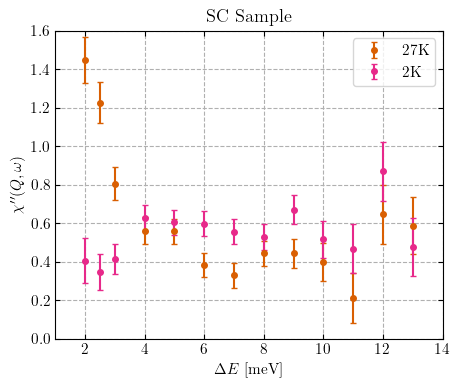

In [28]:
plot_formalia('$\Delta E$ [meV]', '$\chi\'\'(Q,\omega)$', 'SC Sample', fig_size=(5,4))
plt.ylim(0, 1.6)
plt.xlim(1, 14)

#plt.errorbar(sc_mevs_q_27K, sc_q_27K_intensity, yerr = sc_err_q_27K_intensity, fmt = 'o', label = 'q-scans 27K')
plt.errorbar(sc_tre_27K_mevs, sc_tre_27K_intensity, capsize = 2, fmt ='o', yerr = sc_err_tre_27K_intensity, label = '27K', color='#d95f02')
plt.errorbar(sc_tre_2K_mevs, sc_tre_2K_intensity, capsize = 2, fmt ='o', yerr = sc_err_tre_2K_intensity, label = '2K', color ='#e7298a')
plt.legend(fontsize=11)

plt.savefig('SC_E_Dependence.eps', format='eps')

In [29]:
# 5K
sc_tre_5K_2mev = np.genfromtxt('./Data/038427', skip_header = 63)
sc_tre_5K_2mev_1 = np.genfromtxt('./Data/038428', skip_header = 63)
sc_tre_5K_2mev[1,8] = sc_tre_5K_2mev[1,8] + sc_tre_5K_2mev_1[8]
sc_tre_5K_2mev_peak = tre_punkt(sc_tre_5K_2mev[:,8],)/240000000

sc_tre_5K_8mev = np.genfromtxt('./Data/038429', skip_header = 63)
sc_tre_5K_8mev_1 = np.genfromtxt('./Data/038430', skip_header = 63)
sc_tre_5K_8mev[1,8] = sc_tre_5K_8mev[1,8] + sc_tre_5K_8mev_1[8]
sc_tre_5K_8mev_peak = tre_punkt(sc_tre_5K_8mev[:,8],)/240000000

# 8K
sc_tre_8K_2mev = np.genfromtxt('./Data/038431', skip_header = 63)
sc_tre_8K_2mev_1 = np.genfromtxt('./Data/038432', skip_header = 63)
sc_tre_8K_2mev[1,8] = sc_tre_8K_2mev[1,8] + sc_tre_8K_2mev_1[8]
sc_tre_8K_2mev_peak = tre_punkt(sc_tre_8K_2mev[:,8],)/240000000

sc_tre_8K_8mev = np.genfromtxt('./Data/038433', skip_header = 63)
sc_tre_8K_8mev_1 = np.genfromtxt('./Data/038434', skip_header = 63)
sc_tre_8K_8mev[1,8] = sc_tre_8K_8mev[1,8] + sc_tre_8K_8mev_1[8]
sc_tre_8K_8mev_peak = tre_punkt(sc_tre_8K_8mev[:,8],)/240000000

# 10K
sc_tre_10K_2mev = np.genfromtxt('./Data/038435', skip_header = 63)
sc_tre_10K_2mev_1 = np.genfromtxt('./Data/038436', skip_header = 63)
sc_tre_10K_2mev[1,8] = sc_tre_10K_2mev[1,8] + sc_tre_10K_2mev_1[8]
sc_tre_10K_2mev_peak = tre_punkt(sc_tre_10K_2mev[:,8],)/240000000

sc_tre_10K_8mev = np.genfromtxt('./Data/038437', skip_header = 63)
sc_tre_10K_8mev_1 = np.genfromtxt('./Data/038438', skip_header = 63)
sc_tre_10K_8mev[1,8] = sc_tre_10K_8mev[1,8] + sc_tre_10K_8mev_1[8]
sc_tre_10K_8mev_peak = tre_punkt(sc_tre_10K_8mev[:,8],)/240000000

# 15K
sc_tre_15K_2mev = np.genfromtxt('./Data/038439', skip_header = 63)
sc_tre_15K_2mev_1 = np.genfromtxt('./Data/038440', skip_header = 63)
sc_tre_15K_2mev[1,8] = sc_tre_15K_2mev[1,8] + sc_tre_15K_2mev_1[8]
sc_tre_15K_2mev_peak = tre_punkt(sc_tre_15K_2mev[:,8],)/240000000

sc_tre_15K_8mev = np.genfromtxt('./Data/038441', skip_header = 63)
sc_tre_15K_8mev_1 = np.genfromtxt('./Data/038442', skip_header = 63)
sc_tre_15K_8mev[1,8] = sc_tre_15K_8mev[1,8] + sc_tre_15K_8mev_1[8]
sc_tre_15K_8mev_peak = tre_punkt(sc_tre_15K_8mev[:,8],)/240000000

# 20K
sc_tre_20K_2mev = np.genfromtxt('./Data/038443', skip_header = 63)
sc_tre_20K_2mev_1 = np.genfromtxt('./Data/038444', skip_header = 63)
sc_tre_20K_2mev[1,8] = sc_tre_20K_2mev[1,8] + sc_tre_20K_2mev_1[8]
sc_tre_20K_2mev_peak = tre_punkt(sc_tre_20K_2mev[:,8],)/240000000

sc_tre_20K_8mev = np.genfromtxt('./Data/038445', skip_header = 63)
sc_tre_20K_8mev_1 = np.genfromtxt('./Data/038446', skip_header = 63)
sc_tre_20K_8mev[1,8] = sc_tre_20K_8mev[1,8] + sc_tre_20K_8mev_1[8]
sc_tre_20K_8mev_peak = tre_punkt(sc_tre_20K_8mev[:,8],)/240000000

# 23K
sc_tre_23K_2mev = np.genfromtxt('./Data/038447', skip_header = 63)
sc_tre_23K_2mev_1 = np.genfromtxt('./Data/038448', skip_header = 63)
sc_tre_23K_2mev[1,8] = sc_tre_23K_2mev[1,8] + sc_tre_23K_2mev_1[8]
sc_tre_23K_2mev_peak = tre_punkt(sc_tre_23K_2mev[:,8],)/240000000

sc_tre_23K_8mev = np.genfromtxt('./Data/038449', skip_header = 63)
sc_tre_23K_8mev_1 = np.genfromtxt('./Data/038450', skip_header = 63)
sc_tre_23K_8mev[1,8] = sc_tre_23K_8mev[1,8] + sc_tre_23K_8mev_1[8]
sc_tre_23K_8mev_peak = tre_punkt(sc_tre_23K_8mev[:,8],)/240000000

# 30K
sc_tre_30K_2mev = np.genfromtxt('./Data/038461', skip_header = 63)
sc_tre_30K_2mev_1 = np.genfromtxt('./Data/038462', skip_header = 63)
sc_tre_30K_2mev[1,8] = sc_tre_30K_2mev[1,8] + sc_tre_30K_2mev_1[8]
sc_tre_30K_2mev_peak = tre_punkt(sc_tre_30K_2mev[:,8],)/240000000

sc_tre_30K_8mev = np.genfromtxt('./Data/038463', skip_header = 63)
sc_tre_30K_8mev_1 = np.genfromtxt('./Data/038464', skip_header = 63)
sc_tre_30K_8mev[1,8] = sc_tre_30K_8mev[1,8] + sc_tre_30K_8mev_1[8]
sc_tre_30K_8mev_peak = tre_punkt(sc_tre_30K_8mev[:,8],)/240000000

# 35K
sc_tre_35K_2mev = np.genfromtxt('./Data/038465', skip_header = 63)
sc_tre_35K_2mev_1 = np.genfromtxt('./Data/038466', skip_header = 63)
sc_tre_35K_2mev[1,8] = sc_tre_35K_2mev[1,8] + sc_tre_35K_2mev_1[8]
sc_tre_35K_2mev_peak = tre_punkt(sc_tre_35K_2mev[:,8],)/240000000

sc_tre_35K_8mev = np.genfromtxt('./Data/038467', skip_header = 63)
sc_tre_35K_8mev_1 = np.genfromtxt('./Data/038468', skip_header = 63)
sc_tre_35K_8mev[1,8] = sc_tre_35K_8mev[1,8] + sc_tre_35K_8mev_1[8]
sc_tre_35K_8mev_peak = tre_punkt(sc_tre_35K_8mev[:,8],)/240000000

# 40K
sc_tre_40K_2mev = np.genfromtxt('./Data/038469', skip_header = 63)
sc_tre_40K_2mev_1 = np.genfromtxt('./Data/038470', skip_header = 63)
sc_tre_40K_2mev[1,8] = sc_tre_40K_2mev[1,8] + sc_tre_40K_2mev_1[8]
sc_tre_40K_2mev_peak = tre_punkt(sc_tre_40K_2mev[:,8],)/240000000

sc_tre_40K_8mev = np.genfromtxt('./Data/038471', skip_header = 63)
sc_tre_40K_8mev_1 = np.genfromtxt('./Data/038472', skip_header = 63)
sc_tre_40K_8mev[1,8] = sc_tre_40K_8mev[1,8] + sc_tre_40K_8mev_1[8]
sc_tre_40K_8mev_peak = tre_punkt(sc_tre_40K_8mev[:,8],)/240000000

# 45K
sc_tre_45K_2mev = np.genfromtxt('./Data/038473', skip_header = 63)
sc_tre_45K_2mev_1 = np.genfromtxt('./Data/038474', skip_header = 63)
sc_tre_45K_2mev[1,8] = sc_tre_45K_2mev[1,8] + sc_tre_45K_2mev_1[8]
sc_tre_45K_2mev_peak = tre_punkt(sc_tre_45K_2mev[:,8],)/240000000

sc_tre_45K_8mev = np.genfromtxt('./Data/038475', skip_header = 63)
sc_tre_45K_8mev_1 = np.genfromtxt('./Data/038476', skip_header = 63)
sc_tre_45K_8mev[1,8] = sc_tre_45K_8mev[1,8] + sc_tre_45K_8mev_1[8]
sc_tre_45K_8mev_peak = tre_punkt(sc_tre_45K_8mev[:,8],)/240000000
    

sc_tre_2mev_temp_peaks = np.array([sc_tre_2K_2mev_peak,
                                   sc_tre_5K_2mev_peak, 
                                   sc_tre_8K_2mev_peak, 
                                   sc_tre_10K_2mev_peak, 
                                   sc_tre_15K_2mev_peak, 
                                   sc_tre_20K_2mev_peak, 
                                   sc_tre_23K_2mev_peak, 
                                   sc_tre_27K_2mev_peak, 
                                   sc_tre_30K_2mev_peak, 
                                   sc_tre_35K_2mev_peak, 
                                   sc_tre_40K_2mev_peak, 
                                   sc_tre_45K_2mev_peak])/sc_phonon_normalisation * width_sc
sc_err_tre_2mev_temp_peaks = np.array([usikkerhed_tre_punkt(sc_tre_2K_2mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_5K_2mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_8K_2mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_10K_2mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_15K_2mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_20K_2mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_23K_2mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_27K_2mev[:,8])/300000000,
                                       usikkerhed_tre_punkt(sc_tre_30K_2mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_35K_2mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_40K_2mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_45K_2mev[:,8])/240000000]) /sc_phonon_normalisation * width_sc
sc_tre_8mev_temp_peaks = np.array([sc_tre_2K_8mev_peak,
                                   sc_tre_5K_8mev_peak, 
                                   sc_tre_8K_8mev_peak, 
                                   sc_tre_10K_8mev_peak, 
                                   sc_tre_15K_8mev_peak, 
                                   sc_tre_20K_8mev_peak, 
                                   sc_tre_23K_8mev_peak, 
                                   sc_tre_27K_8mev_peak, 
                                   sc_tre_30K_8mev_peak, 
                                   sc_tre_35K_8mev_peak, 
                                   sc_tre_40K_8mev_peak, 
                                   sc_tre_45K_8mev_peak])/sc_phonon_normalisation * width_sc
sc_err_tre_8mev_temp_peaks = np.array([usikkerhed_tre_punkt(sc_tre_2K_8mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_5K_8mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_8K_8mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_10K_8mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_15K_8mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_20K_8mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_23K_8mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_27K_8mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_30K_8mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_35K_8mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_40K_8mev[:,8])/240000000,
                                       usikkerhed_tre_punkt(sc_tre_45K_8mev[:,8])/240000000]) /sc_phonon_normalisation * width_sc
sc_tre_temps = np.array([2, 5, 8, 10, 15, 20, 23, 27, 30, 35, 40, 45])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


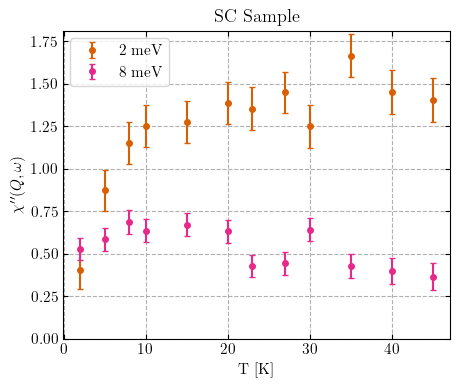

In [30]:
plot_formalia('T [K]', '$\chi\'\'(Q,\omega)$', 'SC Sample')
plt.ylim(0, 1.81)
plt.errorbar(sc_tre_temps, sc_tre_2mev_temp_peaks, capsize = 2, fmt ='o', yerr = sc_err_tre_2mev_temp_peaks, label = '2 meV', color= '#d95f02')
plt.errorbar(sc_tre_temps, sc_tre_8mev_temp_peaks, capsize = 2, fmt ='o', yerr = sc_err_tre_8mev_temp_peaks, label = '8 meV', color= '#e7298a')

plt.legend(fontsize=11)
plt.savefig('SC_T_dependence.eps', format='eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


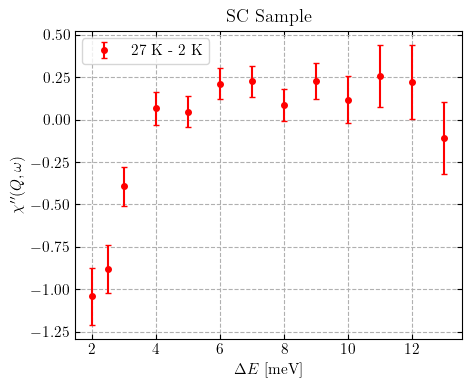

In [31]:
x= np.linspace(1, 14, 100)

plot_formalia('$\Delta E$  [meV]', '$\chi\'\'(Q,\omega)$','SC Sample')
plt.errorbar(sc_tre_2K_mevs, sc_tre_2K_intensity - sc_tre_27K_intensity, capsize = 2, fmt ='o', yerr = np.sqrt(sc_err_tre_27K_intensity**2 + sc_err_tre_2K_intensity**2), label = '27 K - 2 K ', color='red')
plt.legend(fontsize = 11)

plt.savefig('SC_E_difference.eps', format='eps')


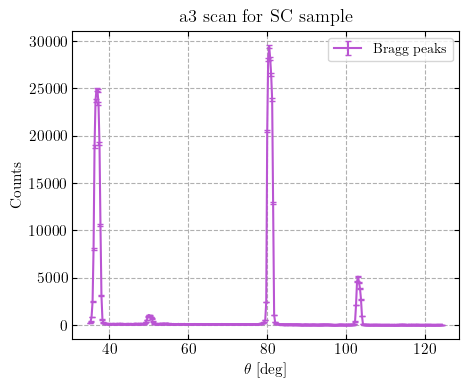

In [32]:
#two crystalites
twins = np.genfromtxt('./Data/038340', skip_header = 63)

plot_formalia(r'$\theta $ [deg]', 'Counts', 'a3 scan for SC sample')
plt.errorbar(twins[:,1], twins[:,5], yerr = np.sqrt(twins[:,5]), color = 'mediumorchid' , label = 'Bragg peaks')


plt.legend(fontsize = 10)


# AG sample
### Q scans

In [33]:
#Normalisation to the phonon
F_ag = 0
#Jeg regner hvert atom for sig, rækkefølge Nd, Ce, Cu, O 
for i in range(len(Nd_Ce)):
    F_ag += 0.935 * structure_factor_elements_for_sum(f_Nd, Nd_Ce[i,0], Nd_Ce[i,1], Nd_Ce[i,2], 1.9998, 0, 0.0000)
print(np.abs(F_ag)**2)
for i in range(len(Nd_Ce)):
    F_ag += 0.065 * structure_factor_elements_for_sum(f_Ce, Nd_Ce[i,0], Nd_Ce[i,1], Nd_Ce[i,2], 1.9998, 0, 0.0000)
print(np.abs(F_ag)**2)
for i in range(len(Cu)):
    F_ag += structure_factor_elements_for_sum(f_Cu, Cu[i,0], Cu[i,1], Cu[i,2], 1.9998, 0, 0.0000)
print(np.abs(F_ag)**2)
for i in range(len(O)):
    F_ag += structure_factor_elements_for_sum(f_O, O[i,0], O[i,1], O[i,2], 1.9998, 0, 0.0000)
    
print('F_N(Q) =', np.abs(F_ag), 'm') 
F_ag_ianden = np.abs(F_ag)**2 * 10**(28)
print('abs(F_N(Q))^2 =', F_ag_ianden, 'barn')


8.27172030721388e-28
9.011402720610148e-28
2.0661568210784832e-27
F_N(Q) = 9.187899204163512e-14 m
abs(F_N(Q))^2 = 84.41749178586849 barn


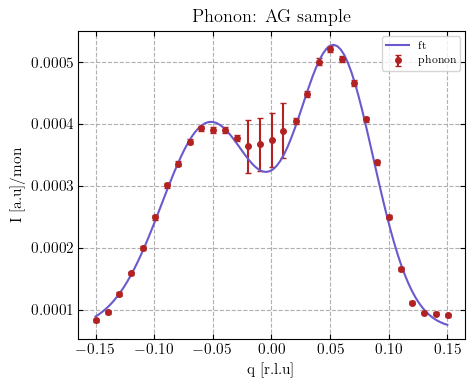

In [34]:
# Her finder jeg domega/dq
# Jeg identificerer peaks i min phonon scanning
ag_phonon = np.genfromtxt('./Data/038498', skip_header = 63)

err_ag_phonon = np.sqrt(ag_phonon[:,8])/20e+6
err_ag_phonon[13:17] = err_ag_phonon[13:17]*10

plot_formalia('q [r.l.u]', 'I [a.u]/mon', 'Phonon: AG sample')
plt.errorbar(ag_phonon[:,2], ag_phonon[:,8]/20e+6, capsize = 2, yerr = err_ag_phonon, fmt = 'o', label = 'phonon', color = 'firebrick')

guess = [ 1.11909676e-04, -7.53678518e-02,  4.00355575e-02,  1.75494263e-04,  4.73632460e-02,  2.64055694e-02, 0.000009]
#             A               Mu                Sigma            A2               Mu2             sigma2      lin_offset
par, cov = curve_fit(combined, ag_phonon[:,2], ydata = ag_phonon[:,8]/20e+6, sigma = err_ag_phonon, absolute_sigma=True, p0 = (guess))

x = np.linspace(-.15, .15, 100)
plt.plot(x, combined(x, *par), label = 'ft', color = 'slateblue')
plt.legend(fontsize=8)

domega_ag = 3.0005 #meV Jeg er uklar på hvorfor jeg ikke skal dividere med h_bar, Henrik kigger på det. 
dq_ag = par[4]

domega_dq_ag = domega_ag / dq_ag # meV/r.l.u. (r.l.u. er reciprocal lattice units) 


In [35]:
#Here I calculate the (hbarQ)^2/2m for the superconducting sample (Q_h, Q_k, a = 3.9422)

hbar_Q_i_anden_over_2_m_ag = hbar_Q_i_anden_over_2_m (1.9998, dq_ag)
print(hbar_Q_i_anden_over_2_m_ag)


21.239543438685303


In [36]:
# Nu regner jeg n(q)/h_bar omega
# Vi har målt phononen ved 100K, 3.0005 meV

energy_phonon_ag = 3.0005 #meV
phonon_k_B_T = 0.08617 * 100 #meV K / K

#h_bar_meV = 6.582 * 10**(-13) #meV s

n_q_div_h_bar_omega_ag = 1 / ((1 - np.exp(- energy_phonon_ag / phonon_k_B_T) )* energy_phonon_ag)


In [37]:
# Nu ka jeg finde integralet over intensiteten 
from scipy import integrate
doubble_gauss_lin_offset_ag = lambda x: 3.32196335e-04 *np.exp(-(x + 5.26794610e-02)**2/(2*(4.09406248e-02)**2)) + 4.47394676e-04 *np.exp(-(x -  5.46142297e-02)**2/(2*(3.26772345e-02)**2)) + 6.91584554e-05 #Det er en dobbelt gaus med de fittede parametre 

integral_ag_positive = integrate.quad(doubble_gauss_lin_offset_ag, -.02, 0.15)
integral_ag_negative = integrate.quad(doubble_gauss_lin_offset_ag, -0.15, -.02)


integral_ag = (integral_ag_negative[0] + integral_ag_positive[0])/2
print(par)

[ 3.32196335e-04 -5.26794609e-02  4.09406249e-02  4.47394676e-04
  5.46142297e-02  3.26772344e-02  6.91584555e-05]


In [38]:
# Nu ka jeg finde Nk_fR_0
Nk_fR_0_ag = integral_ag / (1 / domega_dq_ag * n_q_div_h_bar_omega_ag * hbar_Q_i_anden_over_2_m_ag * m_div_M * F_ag_ianden)

print(Nk_fR_0_ag)


0.0010142155281795942


In [39]:
#Now I can convert to either S or X''
S_of_Q_and_E_ag = 13.77/Nk_fR_0_ag #meV 

ag_phonon_normalisation = 1 / (10**3 * np.pi / 2 * 13.77 / (magnetic_form_factor**2 * Nk_fR_0_ag)) #mu_B eV^-1  10^3 converts to eV^-1

print(1/ag_phonon_normalisation)


8382054.500465687


In [40]:
#27K
#Der er 2 filer for 8meV, fordi vi gerne ville have ekstra data her, da det er de vigtige q-scans
ag_q_27K_2mev = np.genfromtxt('./Data/038502', skip_header = 63)
ag_q_27K_2mev_1 = np.genfromtxt('./Data/038514', skip_header = 63)
ag_q_27K_2mev[:,8] = ag_q_27K_2mev[:,8] + ag_q_27K_2mev_1[:,8]

ag_q_27K_2_5mev = np.genfromtxt('./Data/038503', skip_header = 63)
ag_q_27K_3mev = np.genfromtxt('./Data/038504', skip_header = 63)
ag_q_27K_4mev = np.genfromtxt('./Data/038505', skip_header = 63)
ag_q_27K_5mev = np.genfromtxt('./Data/038506', skip_header = 63)
ag_q_27K_6mev = np.genfromtxt('./Data/038507', skip_header = 63) 
ag_q_27K_7mev = np.genfromtxt('./Data/038508', skip_header = 63) 

ag_q_27K_8mev = np.genfromtxt('./Data/038500', skip_header = 63)
ag_q_27K_8mev_2 = np.genfromtxt('./Data/038501', skip_header = 63)
ag_q_27K_8mev[:,8] = ag_q_27K_8mev[:,8] + ag_q_27K_8mev_2[:,8]

ag_q_27K_9mev = np.genfromtxt('./Data/038509', skip_header = 63) 
ag_q_27K_10mev = np.genfromtxt('./Data/038510', skip_header = 63) 
ag_q_27K_10_5mev = np.genfromtxt('./Data/038557', skip_header = 63) 

ag_q_27K_11mev = np.genfromtxt('./Data/038511', skip_header = 63) 
ag_q_27K_11mev_1 = np.genfromtxt('./Data/038558', skip_header = 63)
ag_q_27K_11mev[:,8] = ag_q_27K_11mev[:,8] + ag_q_27K_11mev_1[:,8]

ag_q_27K_12mev = np.genfromtxt('./Data/038512', skip_header = 63) 
ag_q_27K_12mev_1 = np.genfromtxt('./Data/038559', skip_header = 63)
ag_q_27K_12mev[:,8] = ag_q_27K_12mev[:,8] + ag_q_27K_12mev_1[:,8]

ag_q_27K_13mev = np.genfromtxt('./Data/038513', skip_header = 63) 
ag_q_27K_13mev_1 = np.genfromtxt('./Data/038560', skip_header = 63)
ag_q_27K_13mev[:,8] = ag_q_27K_13mev[:,8] + ag_q_27K_13mev_1[:,8]


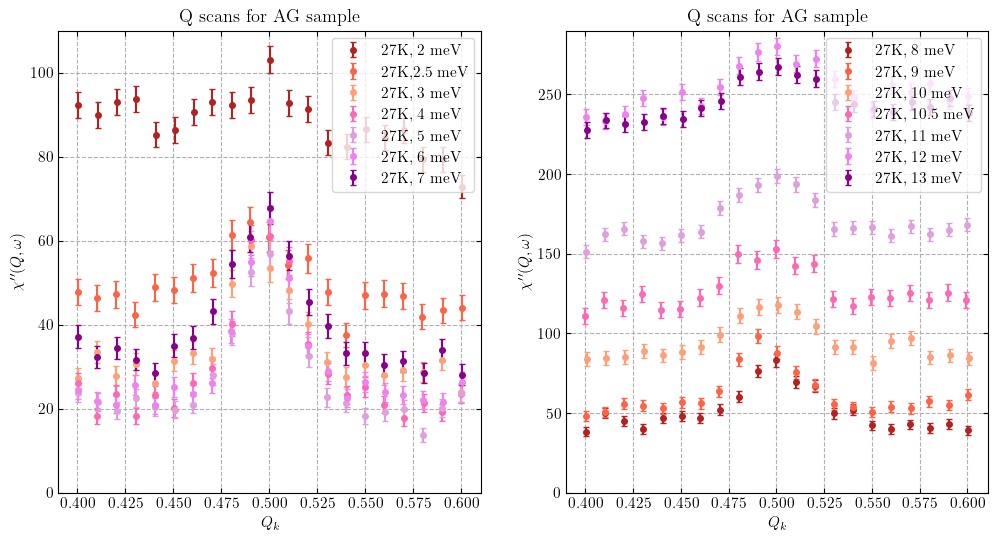

In [41]:
#plot_formalia('Qk', 'counts', 'data', fig_size = (6,6))
#27K
fig,ax = plt.subplots(1,2, figsize = (12,6))
#fig.set_title('Simple plot')

#fig.figure()

ax[0].set_ylabel('$\chi\'\'(Q,\omega)$')
ax[0].set_xlabel('$Q_k$')
ax[0].set_title('Q scans for AG sample')
ax[0].set_ylim([0, 110])
ax[0].grid(linestyle = '--')
ax[1].set_xlabel('$Q_k$')
ax[1].set_ylabel('$\chi\'\'(Q,\omega)$')
ax[1].set_title('Q scans for AG sample')
ax[1].set_ylim([0, 290])
ax[1].grid(linestyle = '--')
   
ax[0].errorbar(ag_q_27K_2mev[:,2], ag_q_27K_2mev[:,8]/80000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_2mev[:,8])/80000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 2 meV', color = 'firebrick')
ax[0].errorbar(ag_q_27K_2_5mev[:,2], ag_q_27K_2_5mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_2_5mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '27K,2.5 meV', color = 'tomato')
ax[0].errorbar(ag_q_27K_3mev[:,2], ag_q_27K_3mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_3mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 3 meV', color = 'lightsalmon')
ax[0].errorbar(ag_q_27K_4mev[:,2], ag_q_27K_4mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_4mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 4 meV', color = 'hotpink')
ax[0].errorbar(ag_q_27K_5mev[:,2], ag_q_27K_5mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_5mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 5 meV', color = 'plum')
ax[0].errorbar(ag_q_27K_6mev[:,2], ag_q_27K_6mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_6mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 6 meV', color = 'violet')
ax[0].errorbar(ag_q_27K_7mev[:,2], ag_q_27K_7mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_7mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 7 meV', color = 'darkmagenta')

ax[1].errorbar(ag_q_27K_8mev[:,2], ag_q_27K_8mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_8mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 8 meV', color = 'firebrick')
ax[1].errorbar(ag_q_27K_9mev[:,2], ag_q_27K_9mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_9mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 9 meV', color = 'tomato')
ax[1].errorbar(ag_q_27K_10mev[:,2], ag_q_27K_10mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_10mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 10 meV', color = 'lightsalmon')
ax[1].errorbar(ag_q_27K_10_5mev[:,2], ag_q_27K_10_5mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_10_5mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 10.5 meV', color = 'hotpink')
ax[1].errorbar(ag_q_27K_11mev[:,2], ag_q_27K_11mev[:,8]/80000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_11mev[:,8])/80000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 11 meV', color = 'plum')
ax[1].errorbar(ag_q_27K_12mev[:,2], ag_q_27K_12mev[:,8]/80000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_12mev[:,8])/80000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 12 meV', color = 'violet')
ax[1].errorbar(ag_q_27K_13mev[:,2], ag_q_27K_13mev[:,8]/80000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_13mev[:,8])/80000000/ag_phonon_normalisation, fmt = 'o', label = '27K, 13 meV', color = 'darkmagenta')

ax[0].legend()
ax[1].legend()


In [42]:
#27K
#2meV
ag_startguess_27K_2mev = [200, .025, .5, 300]
ag_par_q_27K_2mev, ag_cov_q_27K_2mev = curve_fit(gauss, ag_q_27K_2mev[:,2], ag_q_27K_2mev[:,8], sigma = np.sqrt(ag_q_27K_2mev[:,8]), p0 = ag_startguess_27K_2mev)

#2.5meV
ag_startguess_27K_2_5mev = [200, .025, .5, 300]
ag_par_q_27K_2_5mev, ag_cov_q_27K_2_5mev = curve_fit(gauss, ag_q_27K_2_5mev[:,2], ag_q_27K_2_5mev[:,8], sigma = np.sqrt(ag_q_27K_2_5mev[:,8]), p0 = ag_startguess_27K_2_5mev)

#3meV
ag_startguess_27K_3mev = [200, .025, .5, 300]
ag_par_q_27K_3mev, ag_cov_q_27K_3mev = curve_fit(gauss, ag_q_27K_3mev[:,2], ag_q_27K_3mev[:,8], sigma = np.sqrt(ag_q_27K_3mev[:,8]), p0 = ag_startguess_27K_3mev)

#4meV
ag_startguess_27K_4mev = [200, .025, .5, 300]
ag_par_q_27K_4mev, ag_cov_q_27K_4mev = curve_fit(gauss, ag_q_27K_4mev[:,2], ag_q_27K_4mev[:,8], sigma = np.sqrt(ag_q_27K_4mev[:,8]), p0 = ag_startguess_27K_4mev)

#5meV
ag_startguess_27K_5mev = [200, .025, .5, 300]
ag_par_q_27K_5mev, ag_cov_q_27K_5mev = curve_fit(gauss, ag_q_27K_5mev[:,2], ag_q_27K_5mev[:,8], sigma = np.sqrt(ag_q_27K_5mev[:,8]), p0 = ag_startguess_27K_5mev)

#6meV
ag_startguess_27K_6mev = [200, .025, .5, 300]
ag_par_q_27K_6mev, ag_cov_q_27K_6mev = curve_fit(gauss, ag_q_27K_6mev[:,2], ag_q_27K_6mev[:,8], sigma = np.sqrt(ag_q_27K_6mev[:,8]), p0 = ag_startguess_27K_6mev)

#7meV
ag_startguess_27K_7mev = [200, .025, .5, 300]
ag_par_q_27K_7mev, ag_cov_q_27K_7mev = curve_fit(gauss, ag_q_27K_7mev[:,2], ag_q_27K_7mev[:,8], sigma = np.sqrt(ag_q_27K_7mev[:,8]), p0 = ag_startguess_27K_7mev)

#8meV
ag_startguess_27K_8mev = [200, .025, .5, 300]
ag_par_q_27K_8mev, ag_cov_q_27K_8mev = curve_fit(gauss, ag_q_27K_8mev[:,2], ag_q_27K_8mev[:,8], sigma = np.sqrt(ag_q_27K_8mev[:,8]), p0 = ag_startguess_27K_8mev)

#9meV
ag_startguess_27K_9mev = [200, .025, .5, 300]
ag_par_q_27K_9mev, ag_cov_q_27K_9mev = curve_fit(gauss, ag_q_27K_9mev[:,2], ag_q_27K_9mev[:,8], sigma = np.sqrt(ag_q_27K_9mev[:,8]), p0 = ag_startguess_27K_9mev)

#10meV
ag_startguess_27K_10mev = [200, .025, .5, 300]
ag_par_q_27K_10mev, ag_cov_q_27K_10mev = curve_fit(gauss, ag_q_27K_10mev[:,2], ag_q_27K_10mev[:,8], sigma = np.sqrt(ag_q_27K_10mev[:,8]), p0 = ag_startguess_27K_10mev)

#10,5meV
ag_startguess_27K_10_5mev = [200, .025, .5, 300]
ag_par_q_27K_10_5mev, ag_cov_q_27K_10_5mev = curve_fit(gauss, ag_q_27K_10_5mev[:,2], ag_q_27K_10_5mev[:,8], sigma = np.sqrt(ag_q_27K_10_5mev[:,8]), p0 = ag_startguess_27K_10_5mev)

#11meV
ag_startguess_27K_11mev = [200, .025, .5, 300]
ag_par_q_27K_11mev, ag_cov_q_27K_11mev = curve_fit(gauss, ag_q_27K_11mev[:,2], ag_q_27K_11mev[:,8], sigma = np.sqrt(ag_q_27K_11mev[:,8]), p0 = ag_startguess_27K_11mev)

#12meV
ag_startguess_27K_12mev = [200, .025, .5, 300]
ag_par_q_27K_12mev, ag_cov_q_27K_12mev = curve_fit(gauss, ag_q_27K_12mev[:,2], ag_q_27K_12mev[:,8], sigma = np.sqrt(ag_q_27K_12mev[:,8]), p0 = ag_startguess_27K_12mev)

#13meV
ag_startguess_27K_13mev = [200, .025, .5, 300]
ag_par_q_27K_13mev, ag_cov_q_27K_13mev = curve_fit(gauss, ag_q_27K_13mev[:,2], ag_q_27K_13mev[:,8], sigma = np.sqrt(ag_q_27K_13mev[:,8]), p0 = ag_startguess_27K_13mev)



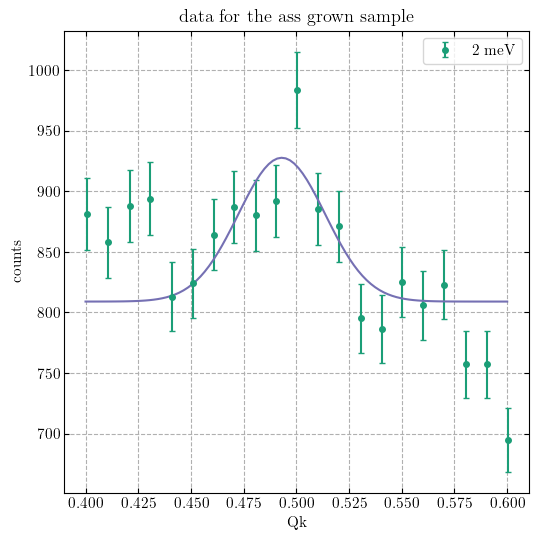

In [43]:
x = np.linspace(.4, .6, 100)

plot_formalia('Qk', 'counts', 'data for the ass grown sample', fig_size = (6,6))
plt.errorbar(ag_q_27K_2mev[:,2], ag_q_27K_2mev[:,8], yerr = np.sqrt(ag_q_27K_2mev[:,8]), fmt = 'o', label = '2 meV')
plt.plot(x, gauss(x, *ag_par_q_27K_2mev))
plt.legend()


In [44]:
#Når den nye mænde data for 2 meV kommer med så er monitor mængden 80000000
ag_q_27K_intensity_per_monitor = np.array([ag_par_q_27K_2mev[0]/80000000*ag_par_q_27K_2mev[1],
                                           ag_par_q_27K_2_5mev[0]/40000000*ag_par_q_27K_2_5mev[1],
                                           ag_par_q_27K_3mev[0]/40000000*ag_par_q_27K_3mev[1],
                                           ag_par_q_27K_4mev[0]/40000000*ag_par_q_27K_4mev[1],
                                           ag_par_q_27K_5mev[0]/40000000*ag_par_q_27K_5mev[1],
                                           ag_par_q_27K_6mev[0]/40000000*ag_par_q_27K_6mev[1],
                                           ag_par_q_27K_7mev[0]/40000000*ag_par_q_27K_7mev[1],
                                           ag_par_q_27K_8mev[0]/40000000*ag_par_q_27K_8mev[1],
                                           ag_par_q_27K_9mev[0]/40000000*ag_par_q_27K_9mev[1],
                                           ag_par_q_27K_10mev[0]/40000000*ag_par_q_27K_10mev[1],
                                           ag_par_q_27K_10_5mev[0]/40000000*ag_par_q_27K_10_5mev[1],
                                           ag_par_q_27K_11mev[0]/80000000*ag_par_q_27K_11mev[1],
                                           ag_par_q_27K_12mev[0]/80000000*ag_par_q_27K_12mev[1],
                                           ag_par_q_27K_13mev[0]/80000000*ag_par_q_27K_13mev[1]])/ag_phonon_normalisation
                                           
ag_err_q_27K_intensity_per_monitor = np.array([np.sqrt((np.sqrt(ag_cov_q_27K_2mev[0,0]) * ag_par_q_27K_2mev[1])**2 + (np.sqrt(ag_cov_q_27K_2mev[1,1]) * ag_par_q_27K_2mev[0])**2)/80000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_2_5mev[0,0]) * ag_par_q_27K_2_5mev[1])**2 + (np.sqrt(ag_cov_q_27K_2_5mev[1,1]) * ag_par_q_27K_2_5mev[0])**2)/40000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_3mev[0,0]) * ag_par_q_27K_3mev[1])**2 + (np.sqrt(ag_cov_q_27K_3mev[1,1]) * ag_par_q_27K_3mev[0])**2)/40000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_4mev[0,0]) * ag_par_q_27K_4mev[1])**2 + (np.sqrt(ag_cov_q_27K_4mev[1,1]) * ag_par_q_27K_4mev[0])**2)/40000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_5mev[0,0]) * ag_par_q_27K_5mev[1])**2 + (np.sqrt(ag_cov_q_27K_5mev[1,1]) * ag_par_q_27K_5mev[0])**2)/40000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_6mev[0,0]) * ag_par_q_27K_6mev[1])**2 + (np.sqrt(ag_cov_q_27K_6mev[1,1]) * ag_par_q_27K_6mev[0])**2)/40000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_7mev[0,0]) * ag_par_q_27K_7mev[1])**2 + (np.sqrt(ag_cov_q_27K_7mev[1,1]) * ag_par_q_27K_7mev[0])**2)/40000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_8mev[0,0]) * ag_par_q_27K_8mev[1])**2 + (np.sqrt(ag_cov_q_27K_8mev[1,1]) * ag_par_q_27K_8mev[0])**2)/40000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_9mev[0,0]) * ag_par_q_27K_9mev[1])**2 + (np.sqrt(ag_cov_q_27K_9mev[1,1]) * ag_par_q_27K_9mev[0])**2)/40000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_10mev[0,0]) * ag_par_q_27K_10mev[1])**2 + (ag_cov_q_27K_10mev[1,1] * ag_par_q_27K_10mev[0])**2)/40000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_10_5mev[0,0]) * ag_par_q_27K_10_5mev[1])**2 + (np.sqrt(ag_cov_q_27K_10_5mev[1,1]) * ag_par_q_27K_10_5mev[0])**2)/40000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_11mev[0,0]) * ag_par_q_27K_11mev[1])**2 + (np.sqrt(ag_cov_q_27K_11mev[1,1]) * ag_par_q_27K_11mev[0])**2)/80000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_12mev[0,0]) * ag_par_q_27K_12mev[1])**2 + (np.sqrt(ag_cov_q_27K_12mev[1,1]) * ag_par_q_27K_12mev[0])**2)/80000000,
                                               np.sqrt((np.sqrt(ag_cov_q_27K_13mev[0,0]) * ag_par_q_27K_13mev[1])**2 + (np.sqrt(ag_cov_q_27K_13mev[1,1]) * ag_par_q_27K_13mev[0])**2)/80000000])/ag_phonon_normalisation
ag_mevs_q_27K = np.array([2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10, 10.5, 11, 12, 13])


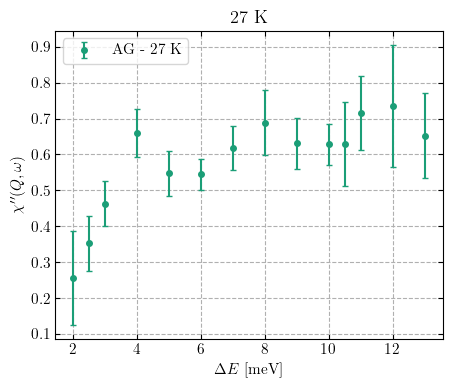

In [45]:
plot_formalia('$\Delta E$ [meV]', '$\chi\'\'(Q,\omega)$', '27 K')#, fig_size = (6,6))
plt.errorbar(ag_mevs_q_27K, ag_q_27K_intensity_per_monitor, capsize = 2, yerr = ag_err_q_27K_intensity_per_monitor, fmt = 'o', label = 'AG - 27 K')
#plt.errorbar(sc_tre_27K_mevs, sc_tre_27K_intensity, fmt ='o', yerr = sc_err_tre_27K_intensity, label = 'SC')
#plt.errorbar(to_K_three_point_mevs, to_K_three_point_scan_intensity, fmt ='o', yerr = to_K_err_three_point_scan, label = '3 point scan, 2K')
plt.legend()


In [46]:
#2K
ag_q_2K_2mev = np.genfromtxt('./Data/038515', skip_header = 63)
ag_q_2K_2_5mev = np.genfromtxt('./Data/038516', skip_header = 63)
ag_q_2K_3mev = np.genfromtxt('./Data/038517', skip_header = 63)
ag_q_2K_4mev = np.genfromtxt('./Data/038518', skip_header = 63)
ag_q_2K_5mev = np.genfromtxt('./Data/038519', skip_header = 63)
ag_q_2K_6mev = np.genfromtxt('./Data/038520', skip_header = 63)
ag_q_2K_7mev = np.genfromtxt('./Data/038521', skip_header = 63)
ag_q_2K_8mev = np.genfromtxt('./Data/038522', skip_header = 63)
ag_q_2K_9mev = np.genfromtxt('./Data/038523', skip_header = 63)
ag_q_2K_10mev = np.genfromtxt('./Data/038524', skip_header = 63)
ag_q_2K_10_5mev = np.genfromtxt('./Data/038551', skip_header = 63) #den her er ny as of 29/5

ag_q_2K_11mev = np.genfromtxt('./Data/038525', skip_header = 63) #Vi har taget to ved 11, jeg ved ikke helt hvorfor  
ag_q_2K_11_2mev = np.genfromtxt('./Data/038552', skip_header = 63) #Vi har taget to ved 11, jeg ved ikke helt hvorfor jeg tror det er fordi der er høje errorbars på 
ag_q_2K_11mev[:,8] = ag_q_2K_11mev[:,8] + ag_q_2K_11_2mev[:,8]

ag_q_2K_12mev = np.genfromtxt('./Data/038526', skip_header = 63) 
ag_q_2K_12_2mev = np.genfromtxt('./Data/038553', skip_header = 63) #Vi har taget to ved 12, jeg ved ikke helt hvorfor jeg tror det er fordi der er høje errorbars på 
ag_q_2K_12mev[:,8] = ag_q_2K_12mev[:,8] + ag_q_2K_12_2mev[:,8]

ag_q_2K_13mev = np.genfromtxt('./Data/038527', skip_header = 63)
ag_q_2K_13_2mev = np.genfromtxt('./Data/038554', skip_header = 63) #Vi har taget to ved 12, jeg ved ikke helt hvorfor jeg tror det er fordi der er høje errorbars på 
ag_q_2K_13mev[:,8] = ag_q_2K_13mev[:,8] + ag_q_2K_13_2mev[:,8]


In [47]:
#2K
#2meV
ag_startguess_2K_2mev = [0, 300]
ag_par_q_2K_2mev, ag_cov_q_2K_2mev = curve_fit(temporary_gauss, ag_q_2K_2mev[:,2], ag_q_2K_2mev[:,8], sigma = np.sqrt(ag_q_2K_2mev[:,8]), p0 = ag_startguess_2K_2mev)

#2.5meV
ag_startguess_2K_2_5mev = [0, 300]
ag_par_q_2K_2_5mev, ag_cov_q_2K_2_5mev = curve_fit(temporary_gauss, ag_q_2K_2_5mev[:,2], ag_q_2K_2_5mev[:,8], sigma = np.sqrt(ag_q_2K_2_5mev[:,8]), p0 = ag_startguess_2K_2_5mev)

#3meV
ag_startguess_2K_3mev = [0, 300]
ag_par_q_2K_3mev, ag_cov_q_2K_3mev = curve_fit(temporary_gauss, ag_q_2K_3mev[:,2], ag_q_2K_3mev[:,8], sigma = np.sqrt(ag_q_2K_3mev[:,8]), p0 = ag_startguess_2K_3mev)

#4meV
ag_startguess_2K_4mev = [0, 300]
ag_par_q_2K_4mev, ag_cov_q_2K_4mev = curve_fit(temporary_gauss, ag_q_2K_4mev[:,2], ag_q_2K_4mev[:,8], sigma = np.sqrt(ag_q_2K_4mev[:,8]), p0 = ag_startguess_2K_4mev)

#5meV
ag_startguess_2K_5mev = [200, .025, .5, 300]
ag_par_q_2K_5mev, ag_cov_q_2K_5mev = curve_fit(gauss, ag_q_2K_5mev[:,2], ag_q_2K_5mev[:,8], sigma = np.sqrt(ag_q_2K_5mev[:,8]), p0 = ag_startguess_2K_5mev)

#6meV
ag_startguess_2K_6mev = [200, .025, .5, 300]
ag_par_q_2K_6mev, ag_cov_q_2K_6mev = curve_fit(gauss, ag_q_2K_6mev[:,2], ag_q_2K_6mev[:,8], sigma = np.sqrt(ag_q_2K_6mev[:,8]), p0 = ag_startguess_2K_6mev)

#7meV
ag_startguess_2K_7mev = [200, .025, .5, 300]
ag_par_q_2K_7mev, ag_cov_q_2K_7mev = curve_fit(gauss, ag_q_2K_7mev[:,2], ag_q_2K_7mev[:,8], sigma = np.sqrt(ag_q_2K_7mev[:,8]), p0 = ag_startguess_2K_7mev)

#8meV
ag_startguess_2K_8mev = [200, .025, .5, 300]
ag_par_q_2K_8mev, ag_cov_q_2K_8mev = curve_fit(gauss, ag_q_2K_8mev[:,2], ag_q_2K_8mev[:,8], sigma = np.sqrt(ag_q_2K_8mev[:,8]), p0 = ag_startguess_2K_8mev)

#9meV
ag_startguess_2K_9mev = [200, .025, .5, 300]
ag_par_q_2K_9mev, ag_cov_q_2K_9mev = curve_fit(gauss, ag_q_2K_9mev[:,2], ag_q_2K_9mev[:,8], sigma = np.sqrt(ag_q_2K_9mev[:,8]), p0 = ag_startguess_2K_9mev)

#10meV
ag_startguess_2K_10mev = [200, .025, .5, 300]
ag_par_q_2K_10mev, ag_cov_q_2K_10mev = curve_fit(gauss, ag_q_2K_10mev[:,2], ag_q_2K_10mev[:,8], sigma = np.sqrt(ag_q_2K_10mev[:,8]), p0 = ag_startguess_2K_10mev)

#10_5meV
ag_startguess_2K_10_5mev = [200, .025, .5, 300]
ag_par_q_2K_10_5mev, ag_cov_q_2K_10_5mev = curve_fit(gauss, ag_q_2K_10_5mev[:,2], ag_q_2K_10_5mev[:,8], sigma = np.sqrt(ag_q_2K_10_5mev[:,8]), p0 = ag_startguess_2K_10_5mev)

#11meV
ag_startguess_2K_11mev = [200, .025, .5, 300]
ag_par_q_2K_11mev, ag_cov_q_2K_11mev = curve_fit(gauss, ag_q_2K_11mev[:,2], ag_q_2K_11mev[:,8], sigma = np.sqrt(ag_q_2K_11mev[:,8]), p0 = ag_startguess_2K_11mev)

#12meV
ag_startguess_2K_12mev = [200, .025, .5, 300]
ag_par_q_2K_12mev, ag_cov_q_2K_12mev = curve_fit(gauss, ag_q_2K_12mev[:,2], ag_q_2K_12mev[:,8], sigma = np.sqrt(ag_q_2K_12mev[:,8]), p0 = ag_startguess_2K_12mev)

#13meV
ag_startguess_2K_13mev = [200, .025, .5, 300]
ag_par_q_2K_13mev, ag_cov_q_2K_13mev = curve_fit(gauss, ag_q_2K_13mev[:,2], ag_q_2K_13mev[:,8], sigma = np.sqrt(ag_q_2K_13mev[:,8]), p0 = ag_startguess_2K_13mev)


2.8851291300810594e-08

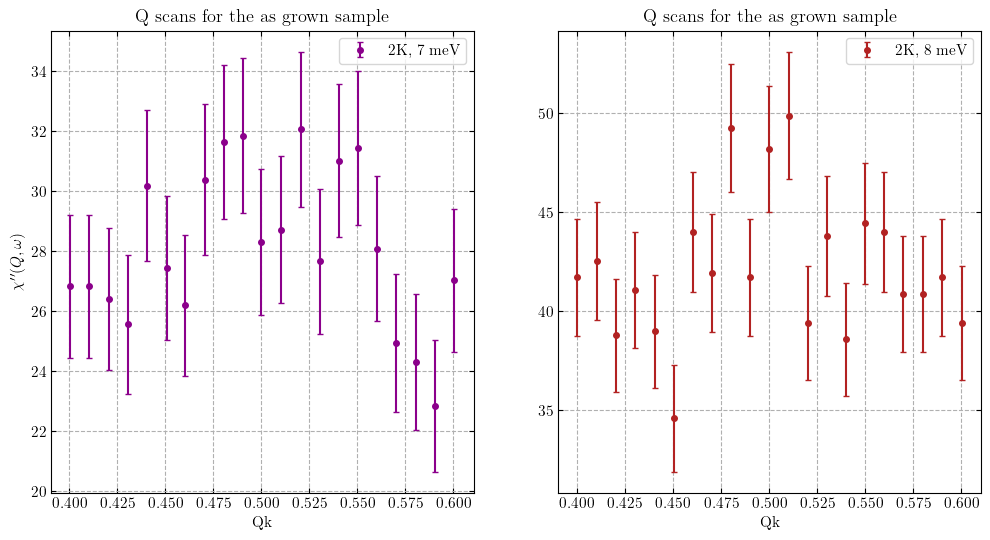

In [48]:
#plot_formalia('Qk', 'Counts per monitor', 'Q-scans for the as grown sample', fig_size = (6,6))
#2K
fig,ax = plt.subplots(1,2, figsize = (12,6))
#fig.set_title('Simple plot')

#fig.figure()
ax[0].set_ylabel('$\chi\'\'(Q,\omega)$')
ax[0].set_xlabel('Qk')
ax[0].set_title('Q scans for the as grown sample')
#ax[0].set_ylim([-0.5, 100])
ax[0].grid(linestyle = '--')
ax[1].set_xlabel('Qk')
ax[1].set_title('Q scans for the as grown sample')
#ax[1].set_ylim([-0.5, 300])
ax[1].grid(linestyle = '--')



#ax[0].errorbar(ag_q_2K_2mev[:,2], ag_q_2K_2mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_2mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 2 meV', color = 'firebrick')
#ax[0].errorbar(ag_q_2K_2_5mev[:,2], ag_q_2K_2_5mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_2_5mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '2K,2.5 meV', color = 'tomato')
#ax[0].errorbar(ag_q_2K_3mev[:,2], ag_q_2K_3mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_3mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 3 meV', color = 'lightsalmon')
#ax[0].errorbar(ag_q_2K_4mev[:,2], ag_q_2K_4mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_4mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 4 meV', color = 'hotpink')
#ax[0].errorbar(ag_q_2K_5mev[:,2], ag_q_2K_5mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_5mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 5 meV', color = 'plum')
#ax[0].errorbar(ag_q_2K_6mev[:,2], ag_q_2K_6mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_6mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 6 meV', color = 'violet')
ax[0].errorbar(ag_q_2K_7mev[:,2], ag_q_2K_7mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_7mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 7 meV', color = 'darkmagenta')

ax[1].errorbar(ag_q_2K_8mev[:,2], ag_q_2K_8mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_8mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 8 meV', color = 'firebrick')
#ax[1].errorbar(ag_q_2K_9mev[:,2], ag_q_2K_9mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_9mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 9 meV', color = 'tomato')
#ax[1].errorbar(ag_q_2K_10mev[:,2], ag_q_2K_10mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_10mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 10 meV', color = 'lightsalmon')
#ax[1].errorbar(ag_q_2K_10_5mev[:,2], ag_q_2K_10_5mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_10_5mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 10.5 meV', color = 'hotpink')
#ax[1].errorbar(ag_q_2K_11mev[:,2], ag_q_2K_11mev[:,8]/80000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_11mev[:,8])/80000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 11 meV', color = 'plum')
#ax[1].errorbar(ag_q_2K_12mev[:,2], ag_q_2K_12mev[:,8]/80000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_12mev[:,8])/80000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 12 meV', color = 'violet')
#ax[1].errorbar(ag_q_2K_13mev[:,2], ag_q_2K_13mev[:,8]/80000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_13mev[:,8])/80000000/ag_phonon_normalisation, fmt = 'o', label = '2K, 13 meV', color = 'darkmagenta')

#lav en version hvor den ikke genbruger farver

ax[0].legend()
ax[1].legend()

np.sqrt((np.sqrt(ag_cov_q_2K_7mev[0,0]) * ag_par_q_2K_7mev[1])**2 + (np.sqrt(ag_cov_q_2K_7mev[1,1]) * ag_par_q_2K_7mev[0])**2)/40000000

[7.04507802 0.0104285  0.00909777 3.21324942]
[1.46069767e+01 2.99620189e-02 8.36276398e-03 1.60552856e+01]
[1.16343816e+01 8.01743435e-03 7.27313578e-03 4.49153151e+00]
8.428057024630891e-08
1.8206461277733564e-07
1.4482727871593115e-07


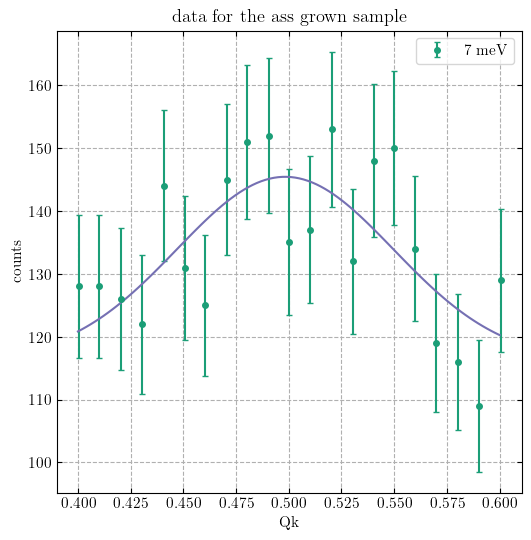

In [49]:
x = np.linspace(.4, .6, 100)

plot_formalia('Qk', 'counts', 'data for the ass grown sample', fig_size = (6,6))
plt.errorbar(ag_q_2K_7mev[:,2], ag_q_2K_7mev[:,8], yerr = np.sqrt(ag_q_2K_7mev[:,8]), fmt = 'o', label = '7 meV')
plt.plot(x, gauss(x, *ag_par_q_2K_7mev))
plt.legend()

#print(ag_par_q_2K_6mev)
#print(ag_par_q_2K_7mev)
#print(ag_par_q_2K_8mev)
perr_2K_6mev = np.sqrt(np.diag(ag_cov_q_2K_6mev))
print(perr_2K_6mev)

perr_2K_7mev = np.sqrt(np.diag(ag_cov_q_2K_7mev))
print(perr_2K_7mev)

perr_2K_8mev = np.sqrt(np.diag(ag_cov_q_2K_8mev))
print(perr_2K_8mev)


print(np.sqrt((np.sqrt(ag_cov_q_2K_6mev[0,0]) * ag_par_q_2K_6mev[2])**2 + (np.sqrt(ag_cov_q_2K_6mev[2,2]) * ag_par_q_2K_6mev[0])**2)/40000000)
print(np.sqrt((np.sqrt(ag_cov_q_2K_7mev[0,0]) * ag_par_q_2K_7mev[2])**2 + (np.sqrt(ag_cov_q_2K_7mev[2,2]) * ag_par_q_2K_7mev[0])**2)/40000000)
print(np.sqrt((np.sqrt(ag_cov_q_2K_8mev[0,0]) * ag_par_q_2K_8mev[2])**2 + (np.sqrt(ag_cov_q_2K_8mev[2,2]) * ag_par_q_2K_8mev[0])**2)/40000000)

In [50]:
#Når den nye mænde data for 2 meV kommer med så er monitor mængden 80000000
ag_q_2K_intensity_per_monitor = np.array([ag_par_q_2K_2mev[0]/40000000 * 2.06256674e-02,
                                           ag_par_q_2K_2_5mev[0]/40000000 * 2.06256674e-02,
                                           ag_par_q_2K_3mev[0]/40000000 * 2.06256674e-02,
                                           ag_par_q_2K_4mev[0]/40000000 * 2.06256674e-02,
                                           ag_par_q_2K_5mev[0]/40000000 * ag_par_q_2K_5mev[1],
                                           ag_par_q_2K_6mev[0]/40000000 * ag_par_q_2K_6mev[1],
                                           ag_par_q_2K_7mev[0]/40000000 * ag_par_q_2K_7mev[1],
                                           ag_par_q_2K_8mev[0]/40000000 * ag_par_q_2K_8mev[1],
                                           ag_par_q_2K_9mev[0]/40000000 * ag_par_q_2K_9mev[1],
                                           ag_par_q_2K_10mev[0]/40000000 * ag_par_q_2K_10mev[1],
                                           ag_par_q_2K_10_5mev[0]/40000000 * ag_par_q_2K_10_5mev[1],
                                           ag_par_q_2K_11mev[0]/80000000 * ag_par_q_2K_11mev[1],
                                           ag_par_q_2K_12mev[0]/80000000 * ag_par_q_2K_12mev[1],
                                           ag_par_q_2K_13mev[0]/80000000 * ag_par_q_2K_13mev[1]])/ag_phonon_normalisation
                                           
ag_err_q_2K_intensity_per_monitor = np.array([np.sqrt(ag_cov_q_2K_2mev[0,0]) * 2.06256674e-02 /40000000,# * ag_cov_q_2K_2mev[1,1],
                                               np.sqrt(ag_cov_q_2K_2_5mev[0,0]) * 2.06256674e-02 /40000000,# * ag_cov_q_2K_2_5mev[1,1],
                                               np.sqrt(ag_cov_q_2K_3mev[0,0]) * 2.06256674e-02 /40000000,# * ag_cov_q_2K_3mev[1,1],
                                               np.sqrt(ag_cov_q_2K_4mev[0,0]) *2.06256674e-02 /40000000,# * ag_cov_q_2K_4mev[1,1],
                                               np.sqrt((np.sqrt(ag_cov_q_2K_5mev[0,0]) * ag_par_q_2K_5mev[1])**2 + (np.sqrt(ag_cov_q_2K_5mev[1,1]) * ag_par_q_2K_5mev[0])**2)/40000000 ,
                                               np.sqrt((np.sqrt(ag_cov_q_2K_6mev[0,0]) * ag_par_q_2K_6mev[1])**2 + (np.sqrt(ag_cov_q_2K_6mev[1,1]) * ag_par_q_2K_6mev[0])**2)/40000000 ,
                                               np.sqrt((np.sqrt(ag_cov_q_2K_7mev[0,0]) * ag_par_q_2K_7mev[1])**2 + (np.sqrt(ag_cov_q_2K_7mev[1,1]) * ag_par_q_2K_7mev[0])**2)/40000000 ,
                                               np.sqrt((np.sqrt(ag_cov_q_2K_8mev[0,0]) * ag_par_q_2K_8mev[1])**2 + (np.sqrt(ag_cov_q_2K_8mev[1,1]) * ag_par_q_2K_8mev[0])**2)/40000000 ,
                                               np.sqrt((np.sqrt(ag_cov_q_2K_9mev[0,0]) * ag_par_q_2K_9mev[1])**2 + (np.sqrt(ag_cov_q_2K_9mev[1,1]) * ag_par_q_2K_9mev[0])**2)/40000000 ,
                                               np.sqrt((np.sqrt(ag_cov_q_2K_10mev[0,0]) * ag_par_q_2K_10mev[1])**2 + (np.sqrt(ag_cov_q_2K_10mev[1,1]) * ag_par_q_2K_10mev[0])**2)/40000000 ,
                                               np.sqrt((np.sqrt(ag_cov_q_2K_10_5mev[0,0]) * ag_par_q_2K_10_5mev[1])**2 + (np.sqrt(ag_cov_q_2K_10_5mev[1,1]) * ag_par_q_2K_10_5mev[0])**2)/40000000 ,
                                               np.sqrt((np.sqrt(ag_cov_q_2K_11mev[0,0]) * ag_par_q_2K_11mev[1])**2 + (np.sqrt(ag_cov_q_2K_11mev[1,1]) * ag_par_q_2K_11mev[0])**2)/80000000 ,
                                               np.sqrt((np.sqrt(ag_cov_q_2K_12mev[0,0]) * ag_par_q_2K_12mev[1])**2 + (np.sqrt(ag_cov_q_2K_12mev[1,1]) * ag_par_q_2K_12mev[0])**2)/80000000 ,
                                               np.sqrt((np.sqrt(ag_cov_q_2K_13mev[0,0]) * ag_par_q_2K_13mev[1])**2 + (np.sqrt(ag_cov_q_2K_13mev[1,1]) * ag_par_q_2K_13mev[0])**2)/80000000 ])/ag_phonon_normalisation
ag_mevs_q_2K = np.array([2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10, 10.5, 11, 12, 13])

print(ag_cov_q_2K_10mev[1,1])
#print(ag_par_q_2K_2mev[0]/40000000 * ag_par_q_2K_2mev[1])#,
#                                           ag_par_q_2K_2_5mev[0]/40000000 * ag_par_q_2K_2_5mev[1],
#                                           ag_par_q_2K_3mev[0]/40000000 * ag_par_q_2K_3mev[1],
#                                           ag_par_q_2K_4mev[0]/40000000 * ag_par_q_2K_4mev[1],
#                                           ag_par_q_2K_5mev[0]/40000000 * ag_par_q_2K_5mev[1],
#                                           ag_par_q_2K_6mev[0]/40000000 * ag_par_q_2K_6mev[1],
#                                           ag_par_q_2K_7mev[0]/40000000 * ag_par_q_2K_7mev[1],
#                                           ag_par_q_2K_8mev[0]/40000000 * ag_par_q_2K_8mev[1],
#                                           ag_par_q_2K_9mev[0]/40000000 * ag_par_q_2K_9mev[1],
#                                           ag_par_q_2K_10mev[0]/40000000 * ag_par_q_2K_10mev[1],
#                                           ag_par_q_2K_10_5mev[0]/40000000 * ag_par_q_2K_10_5mev[1],
#                                           ag_par_q_2K_11mev[0]/80000000 * ag_par_q_2K_11mev[1],
#                                           ag_par_q_2K_12mev[0]/80000000 * ag_par_q_2K_12mev[1],
#                                           ag_par_q_2K_13mev[0]/80000000 * ag_par_q_2K_13mev[1])

3.768229499554816e-05


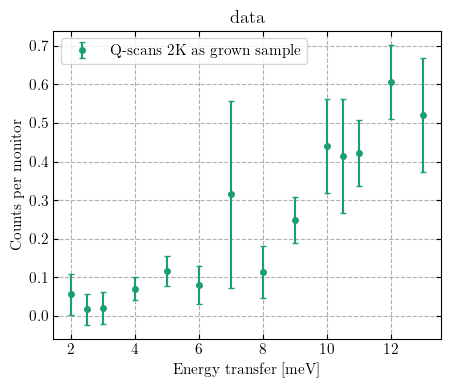

In [51]:
plot_formalia('Energy transfer [meV]', 'Counts per monitor', 'data')#, fig_size = (6,6))
plt.errorbar(ag_mevs_q_2K, ag_q_2K_intensity_per_monitor, capsize = 2, yerr = ag_err_q_2K_intensity_per_monitor, fmt = 'o', label = 'Q-scans 2K as grown sample')
#plt.errorbar(sc_tre_27K_mevs, sc_tre_27K_intensity, fmt ='o', yerr = sc_err_tre_27K_intensity, label = '3 point scan, 27K')
#plt.errorbar(to_K_three_point_mevs, to_K_three_point_scan_intensity, fmt ='o', yerr = to_K_err_three_point_scan, label = '3 point scan, 2K')
plt.legend()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


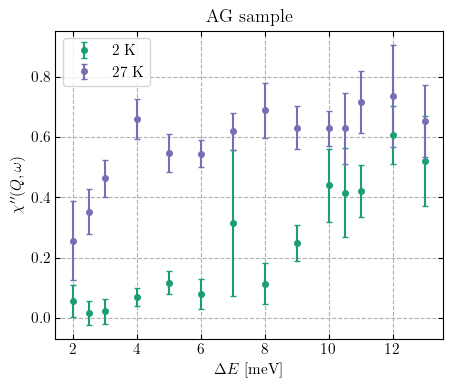

In [52]:
plot_formalia('$\Delta E$ [meV]', '$\chi\'\'(Q,\omega)$', 'AG sample')#, fig_size = (6,6))
#plt.errorbar(ag_mevs_q_27K, ag_q_2K_intensity_per_monitor - ag_q_27K_intensity_per_monitor, yerr = np.sqrt(ag_err_q_27K_intensity_per_monitor**2 + ag_err_q_27K_intensity_per_monitor**2), fmt = 'o', label = 'ag q-scans 2K - 27K')
#plt.errorbar(sc_tre_2K_mevs, sc_tre_2K_intensity - sc_tre_27K_intensity, fmt ='o', yerr = np.sqrt(sc_err_tre_27K_intensity**2 + sc_err_tre_2K_intensity**2), label = 'sc 3 point scan 2K - 27K ')

plt.errorbar(ag_mevs_q_2K, ag_q_2K_intensity_per_monitor, capsize = 2, yerr = ag_err_q_2K_intensity_per_monitor, fmt = 'o', label = '2 K')
plt.errorbar(ag_mevs_q_27K, ag_q_27K_intensity_per_monitor, capsize = 2, yerr = ag_err_q_27K_intensity_per_monitor, fmt = 'o', label = '27 K')

plt.legend(fontsize=11)
plt.savefig('AG_E_dependence.eps', format='eps')

### Temperature sweeps

In [53]:
#3K
ag_q_3K_8mev = np.genfromtxt('./Data/038555', skip_header = 63)

#4K
ag_q_4K_8mev = np.genfromtxt('./Data/038556', skip_header = 63)

#5K
ag_q_5K_2mev = np.genfromtxt('./Data/038528', skip_header = 63)
ag_q_5K_8mev = np.genfromtxt('./Data/038529', skip_header = 63)

#8K
ag_q_8K_2mev = np.genfromtxt('./Data/038530', skip_header = 63)
ag_q_8K_8mev = np.genfromtxt('./Data/038531', skip_header = 63)

#10K
ag_q_10K_2mev = np.genfromtxt('./Data/038532', skip_header = 63)
ag_q_10K_8mev = np.genfromtxt('./Data/038533', skip_header = 63)

#15K
ag_q_15K_2mev = np.genfromtxt('./Data/038534', skip_header = 63)
ag_q_15K_8mev = np.genfromtxt('./Data/038535', skip_header = 63)

#20K
ag_q_20K_2mev = np.genfromtxt('./Data/038536', skip_header = 63)
ag_q_20K_8mev = np.genfromtxt('./Data/038537', skip_header = 63)

#23K
ag_q_23K_2mev = np.genfromtxt('./Data/038538', skip_header = 63)
ag_q_23K_8mev = np.genfromtxt('./Data/038539', skip_header = 63)

#30K
ag_q_30K_2mev = np.genfromtxt('./Data/038540', skip_header = 63)
ag_q_30K_8mev = np.genfromtxt('./Data/038541', skip_header = 63)

#35K
ag_q_35K_2mev = np.genfromtxt('./Data/038542', skip_header = 63)
ag_q_35K_8mev = np.genfromtxt('./Data/038543', skip_header = 63)
                             
#40K
ag_q_40K_2mev = np.genfromtxt('./Data/038544', skip_header = 63)
ag_q_40K_8mev = np.genfromtxt('./Data/038545', skip_header = 63)

#45K
ag_q_45K_2mev = np.genfromtxt('./Data/038546', skip_header = 63)
ag_q_45K_8mev = np.genfromtxt('./Data/038547', skip_header = 63)

#50K
ag_q_50K_2mev = np.genfromtxt('./Data/038549', skip_header = 63)
ag_q_50K_8mev = np.genfromtxt('./Data/038550', skip_header = 63)

#50K
ag_q_55K_2mev = np.genfromtxt('./Data/038561', skip_header = 63)


In [54]:
#3K
ag_startguess_3K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_3K_8mev, ag_cov_q_3K_8mev = curve_fit(gauss, ag_q_3K_8mev[:,2], ag_q_3K_8mev[:,8], sigma = np.sqrt(ag_q_3K_8mev[:,8]), p0 = ag_startguess_3K_8mev)

#4K
ag_startguess_4K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_4K_8mev, ag_cov_q_4K_8mev = curve_fit(gauss, ag_q_4K_8mev[:,2], ag_q_4K_8mev[:,8], sigma = np.sqrt(ag_q_4K_8mev[:,8]), p0 = ag_startguess_4K_8mev)

#5K
ag_startguess_5K_2mev = [0, 300]
ag_par_q_5K_2mev, ag_cov_q_5K_2mev = curve_fit(temporary_gauss, ag_q_5K_2mev[:,2], ag_q_5K_2mev[:,8], sigma = np.sqrt(ag_q_5K_2mev[:,8]), p0 = ag_startguess_5K_2mev, bounds = ([0,0], [np.inf,np.inf]) )
ag_startguess_5K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_5K_8mev, ag_cov_q_5K_8mev = curve_fit(gauss, ag_q_5K_8mev[:,2], ag_q_5K_8mev[:,8], sigma = np.sqrt(ag_q_5K_8mev[:,8]), p0 = ag_startguess_5K_8mev)

#8K
ag_startguess_8K_2mev = [80, 300]
ag_par_q_8K_2mev, ag_cov_q_8K_2mev = curve_fit(temporary_gauss, ag_q_8K_2mev[:,2], ag_q_8K_2mev[:,8], sigma = np.sqrt(ag_q_8K_2mev[:,8]), p0 = ag_startguess_8K_2mev)
ag_startguess_8K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_8K_8mev, ag_cov_q_8K_8mev = curve_fit(gauss, ag_q_8K_8mev[:,2], ag_q_8K_8mev[:,8], sigma = np.sqrt(ag_q_8K_8mev[:,8]), p0 = ag_startguess_8K_8mev)

#10K
ag_startguess_10K_2mev = [80, 300]
ag_par_q_10K_2mev, ag_cov_q_10K_2mev = curve_fit(temporary_gauss, ag_q_10K_2mev[:,2], ag_q_10K_2mev[:,8], sigma = np.sqrt(ag_q_10K_2mev[:,8]), p0 = ag_startguess_10K_2mev)
ag_startguess_10K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_10K_8mev, ag_cov_q_10K_8mev = curve_fit(gauss, ag_q_10K_8mev[:,2], ag_q_10K_8mev[:,8], sigma = np.sqrt(ag_q_10K_8mev[:,8]), p0 = ag_startguess_10K_8mev)

#15K
ag_startguess_15K_2mev = [80, 300]
ag_par_q_15K_2mev, ag_cov_q_15K_2mev = curve_fit(temporary_gauss, ag_q_15K_2mev[:,2], ag_q_15K_2mev[:,8], sigma = np.sqrt(ag_q_15K_2mev[:,8]), p0 = ag_startguess_15K_2mev)
ag_startguess_15K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_15K_8mev, ag_cov_q_15K_8mev = curve_fit(gauss, ag_q_15K_8mev[:,2], ag_q_15K_8mev[:,8], sigma = np.sqrt(ag_q_15K_8mev[:,8]), p0 = ag_startguess_15K_8mev)

#20K
ag_startguess_20K_2mev = [80, 300]
ag_par_q_20K_2mev, ag_cov_q_20K_2mev = curve_fit(temporary_gauss, ag_q_20K_2mev[:,2], ag_q_20K_2mev[:,8], sigma = np.sqrt(ag_q_20K_2mev[:,8]), p0 = ag_startguess_20K_2mev)
ag_startguess_20K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_20K_8mev, ag_cov_q_20K_8mev = curve_fit(gauss, ag_q_20K_8mev[:,2], ag_q_20K_8mev[:,8], sigma = np.sqrt(ag_q_20K_8mev[:,8]), p0 = ag_startguess_20K_8mev)

#23K
ag_startguess_23K_2mev = [80, 300]
ag_par_q_23K_2mev, ag_cov_q_23K_2mev = curve_fit(temporary_gauss, ag_q_23K_2mev[:,2], ag_q_23K_2mev[:,8], sigma = np.sqrt(ag_q_23K_2mev[:,8]), p0 = ag_startguess_23K_2mev)
ag_startguess_23K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_23K_8mev, ag_cov_q_23K_8mev = curve_fit(gauss, ag_q_23K_8mev[:,2], ag_q_23K_8mev[:,8], sigma = np.sqrt(ag_q_23K_8mev[:,8]), p0 = ag_startguess_23K_8mev)

#30K
ag_startguess_30K_2mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_30K_2mev, ag_cov_q_30K_2mev = curve_fit(gauss, ag_q_30K_2mev[:,2], ag_q_30K_2mev[:,8], sigma = np.sqrt(ag_q_30K_2mev[:,8]), p0 = ag_startguess_30K_2mev)
ag_startguess_30K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_30K_8mev, ag_cov_q_30K_8mev = curve_fit(gauss, ag_q_30K_8mev[:,2], ag_q_30K_8mev[:,8], sigma = np.sqrt(ag_q_30K_8mev[:,8]), p0 = ag_startguess_30K_8mev)

#35K
ag_startguess_35K_2mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_35K_2mev, ag_cov_q_35K_2mev = curve_fit(gauss, ag_q_35K_2mev[:,2], ag_q_35K_2mev[:,8], sigma = np.sqrt(ag_q_35K_2mev[:,8]), p0 = ag_startguess_35K_2mev)
ag_startguess_35K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_35K_8mev, ag_cov_q_35K_8mev = curve_fit(gauss, ag_q_35K_8mev[:,2], ag_q_35K_8mev[:,8], sigma = np.sqrt(ag_q_35K_8mev[:,8]), p0 = ag_startguess_35K_8mev)

#40K
ag_startguess_40K_2mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_40K_2mev, ag_cov_q_40K_2mev = curve_fit(gauss, ag_q_40K_2mev[:,2], ag_q_40K_2mev[:,8], sigma = np.sqrt(ag_q_40K_2mev[:,8]), p0 = ag_startguess_40K_2mev)
ag_startguess_40K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_40K_8mev, ag_cov_q_40K_8mev = curve_fit(gauss, ag_q_40K_8mev[:,2], ag_q_40K_8mev[:,8], sigma = np.sqrt(ag_q_40K_8mev[:,8]), p0 = ag_startguess_40K_8mev)

#45K
ag_startguess_45K_2mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_45K_2mev, ag_cov_q_45K_2mev = curve_fit(gauss, ag_q_45K_2mev[:,2], ag_q_45K_2mev[:,8], sigma = np.sqrt(ag_q_45K_2mev[:,8]), p0 = ag_startguess_45K_2mev)
ag_startguess_45K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_45K_8mev, ag_cov_q_45K_8mev = curve_fit(gauss, ag_q_45K_8mev[:,2], ag_q_45K_8mev[:,8], sigma = np.sqrt(ag_q_45K_8mev[:,8]), p0 = ag_startguess_45K_8mev)

#50K
ag_startguess_50K_2mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_50K_2mev, ag_cov_q_50K_2mev = curve_fit(gauss, ag_q_50K_2mev[:,2], ag_q_50K_2mev[:,8], sigma = np.sqrt(ag_q_50K_2mev[:,8]), p0 = ag_startguess_50K_2mev)
ag_startguess_50K_8mev = [200, 2.22378509e-02, .5, 300]
ag_par_q_50K_8mev, ag_cov_q_50K_8mev = curve_fit(gauss, ag_q_50K_8mev[:,2], ag_q_50K_8mev[:,8], sigma = np.sqrt(ag_q_50K_8mev[:,8]), p0 = ag_startguess_50K_8mev)

ag_startguess_55K_2mev = [80, 300]
ag_par_q_55K_2mev, ag_cov_q_55K_2mev = curve_fit(temporary_gauss, ag_q_55K_2mev[:,2], ag_q_55K_2mev[:,8], sigma = np.sqrt(ag_q_55K_2mev[:,8]), p0 = ag_startguess_55K_2mev)

ag_q_2mev_temp_peaks = np.array([ag_par_q_2K_2mev[0]/40000000 * 2.22378509e-02,
                                 ag_par_q_5K_2mev[0]/40000000 * 2.22378509e-02, 
                                 ag_par_q_8K_2mev[0]/40000000 * 2.22378509e-02, 
                                 ag_par_q_10K_2mev[0]/40000000 * 2.22378509e-02, 
                                 ag_par_q_15K_2mev[0]/40000000 * 2.22378509e-02, 
                                 ag_par_q_20K_2mev[0]/40000000 * 2.22378509e-02, 
                                 ag_par_q_23K_2mev[0]/40000000 * 2.22378509e-02, 
                                 ag_par_q_27K_2mev[0]/40000000 * ag_par_q_27K_2mev[1], 
                                 ag_par_q_30K_2mev[0]/40000000 * ag_par_q_30K_2mev[1], 
                                 ag_par_q_35K_2mev[0]/40000000 * ag_par_q_35K_2mev[1], 
                                 ag_par_q_40K_2mev[0]/40000000 * ag_par_q_40K_2mev[1], 
                                 ag_par_q_45K_2mev[0]/40000000 * ag_par_q_45K_2mev[1],
                                 ag_par_q_50K_2mev[0]/40000000 * ag_par_q_50K_2mev[1],
                                 ag_par_q_55K_2mev[0]/40000000 * 2.22378509e-02])/ag_phonon_normalisation
                                        
ag_q_err_2mev_temp_peaks = np.array([np.sqrt(ag_cov_q_2K_2mev[0,0]) * 2.06256674e-02 /40000000,
                                     np.sqrt(ag_cov_q_5K_2mev[0,0]) * 2.06256674e-02 /40000000,
                                     np.sqrt(ag_cov_q_8K_2mev[0,0]) * 2.06256674e-02 /40000000,
                                     np.sqrt(ag_cov_q_10K_2mev[0,0]) * 2.06256674e-02 /40000000,
                                     np.sqrt(ag_cov_q_15K_2mev[0,0]) * 2.06256674e-02 /40000000,
                                     np.sqrt(ag_cov_q_20K_2mev[0,0]) * 2.06256674e-02 /40000000,
                                     np.sqrt(ag_cov_q_23K_2mev[0,0]) * 2.06256674e-02 /40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_27K_2mev[0,0]) * ag_par_q_27K_2mev[1])**2 + (np.sqrt(ag_cov_q_27K_2mev[1,1]) * ag_par_q_27K_2mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_30K_2mev[0,0]) * ag_par_q_30K_2mev[1])**2 + (np.sqrt(ag_cov_q_30K_2mev[1,1]) * ag_par_q_30K_2mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_35K_2mev[0,0]) * ag_par_q_35K_2mev[1])**2 + (np.sqrt(ag_cov_q_35K_2mev[1,1]) * ag_par_q_35K_2mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_40K_2mev[0,0]) * ag_par_q_40K_2mev[1])**2 + (np.sqrt(ag_cov_q_40K_2mev[1,1]) * ag_par_q_40K_2mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_45K_2mev[0,0]) * ag_par_q_45K_2mev[1])**2 + (np.sqrt(ag_cov_q_45K_2mev[1,1]) * ag_par_q_45K_2mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_50K_2mev[0,0]) * ag_par_q_50K_2mev[1])**2 + (np.sqrt(ag_cov_q_50K_2mev[1,1]) * ag_par_q_50K_2mev[0])**2)/40000000,
                                     np.sqrt(ag_cov_q_55K_2mev[0,0]) * 2.06256674e-02 /40000000]) /ag_phonon_normalisation

ag_q_8mev_temp_peaks = np.array([ag_par_q_2K_8mev[0]/40000000 * ag_par_q_2K_8mev[1],
                                 ag_par_q_3K_8mev[0]/40000000 * ag_par_q_3K_8mev[1], 
                                 ag_par_q_4K_8mev[0]/40000000 * ag_par_q_4K_8mev[1], 
                                 ag_par_q_5K_8mev[0]/40000000 * ag_par_q_5K_8mev[1], 
                                 ag_par_q_8K_8mev[0]/40000000 * ag_par_q_8K_8mev[1], 
                                 ag_par_q_10K_8mev[0]/40000000 * ag_par_q_10K_8mev[1], 
                                 ag_par_q_15K_8mev[0]/40000000 * ag_par_q_15K_8mev[1], 
                                 ag_par_q_20K_8mev[0]/40000000 * ag_par_q_20K_8mev[1], 
                                 ag_par_q_23K_8mev[0]/40000000 * ag_par_q_23K_8mev[1], 
                                 ag_par_q_27K_8mev[0]/40000000 * ag_par_q_27K_8mev[1], 
                                 ag_par_q_30K_8mev[0]/40000000 * ag_par_q_30K_8mev[1], 
                                 ag_par_q_35K_8mev[0]/40000000 * ag_par_q_35K_8mev[1], 
                                 ag_par_q_40K_8mev[0]/40000000 * ag_par_q_40K_8mev[1], 
                                 ag_par_q_45K_8mev[0]/40000000 * ag_par_q_45K_8mev[1],
                                 ag_par_q_50K_8mev[0]/40000000 * ag_par_q_50K_8mev[1]])/ag_phonon_normalisation
# 
ag_q_err_8mev_temp_peaks = np.array([np.sqrt((np.sqrt(ag_cov_q_2K_8mev[0,0]) * ag_par_q_2K_8mev[1])**2 + (np.sqrt(ag_cov_q_2K_8mev[1,1]) * ag_par_q_2K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_3K_8mev[0,0]) * ag_par_q_3K_8mev[1])**2 + (np.sqrt(ag_cov_q_3K_8mev[1,1]) * ag_par_q_3K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_4K_8mev[0,0]) * ag_par_q_4K_8mev[1])**2 + (np.sqrt(ag_cov_q_4K_8mev[1,1]) * ag_par_q_4K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_5K_8mev[0,0]) * ag_par_q_5K_8mev[1])**2 + (np.sqrt(ag_cov_q_5K_8mev[1,1]) * ag_par_q_5K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_8K_8mev[0,0]) * ag_par_q_8K_8mev[1])**2 + (np.sqrt(ag_cov_q_8K_8mev[1,1]) * ag_par_q_8K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_10K_8mev[0,0]) * ag_par_q_10K_8mev[1])**2 + (np.sqrt(ag_cov_q_10K_8mev[1,1]) * ag_par_q_10K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_15K_8mev[0,0]) * ag_par_q_15K_8mev[1])**2 + (np.sqrt(ag_cov_q_15K_8mev[1,1]) * ag_par_q_15K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_20K_8mev[0,0]) * ag_par_q_20K_8mev[1])**2 + (np.sqrt(ag_cov_q_20K_8mev[1,1]) * ag_par_q_20K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_23K_8mev[0,0]) * ag_par_q_23K_8mev[1])**2 + (np.sqrt(ag_cov_q_23K_8mev[1,1]) * ag_par_q_23K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_27K_8mev[0,0]) * ag_par_q_27K_8mev[1])**2 + (np.sqrt(ag_cov_q_27K_8mev[1,1]) * ag_par_q_27K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_30K_8mev[0,0]) * ag_par_q_30K_8mev[1])**2 + (np.sqrt(ag_cov_q_30K_8mev[1,1]) * ag_par_q_30K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_35K_8mev[0,0]) * ag_par_q_35K_8mev[1])**2 + (np.sqrt(ag_cov_q_35K_8mev[1,1]) * ag_par_q_35K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_40K_8mev[0,0]) * ag_par_q_40K_8mev[1])**2 + (np.sqrt(ag_cov_q_40K_8mev[1,1]) * ag_par_q_40K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_45K_8mev[0,0]) * ag_par_q_45K_8mev[1])**2 + (np.sqrt(ag_cov_q_45K_8mev[1,1]) * ag_par_q_45K_8mev[0])**2)/40000000,
                                     np.sqrt((np.sqrt(ag_cov_q_50K_8mev[0,0]) * ag_par_q_50K_8mev[1])**2 + (np.sqrt(ag_cov_q_50K_8mev[1,1]) * ag_par_q_50K_8mev[0])**2)/40000000]) /ag_phonon_normalisation

ag_q_temps_2mev = np.array([2, 5, 8, 10, 15, 20, 23, 27, 30, 35, 40, 45, 50, 55])
ag_q_temps_8mev = np.array([2, 3, 4, 5, 8, 10, 15, 20, 23, 27, 30, 35, 40, 45, 50])


[8.83215895e-20 3.85651013e+02]


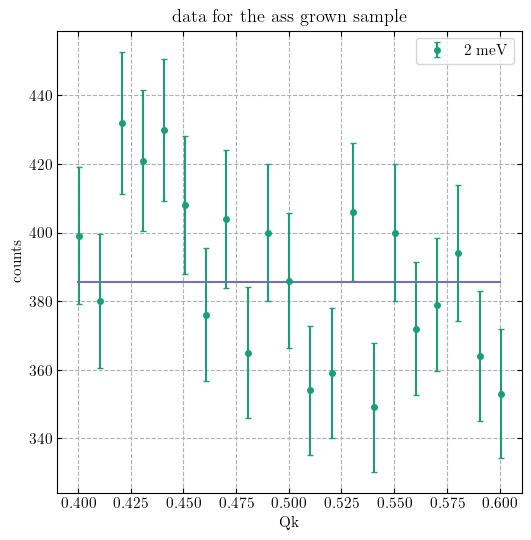

In [55]:
x = np.linspace(.4, .6, 100)

plot_formalia('Qk', 'counts', 'data for the ass grown sample', fig_size = (6,6))
plt.errorbar(ag_q_5K_2mev[:,2], ag_q_5K_2mev[:,8], yerr = np.sqrt(ag_q_5K_2mev[:,8]), fmt = 'o', label = '2 meV')
plt.plot(x, temporary_gauss(x, *ag_par_q_5K_2mev))
plt.legend()

print(ag_par_q_5K_2mev)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


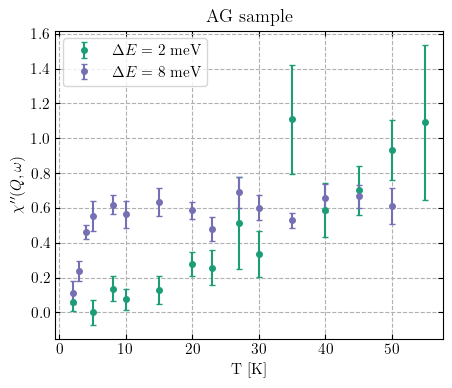

In [56]:
plot_formalia('T [K]', '$\chi\'\'(Q,\omega)$', 'AG sample')#, fig_size = (6,6))
plt.errorbar(ag_q_temps_2mev, ag_q_2mev_temp_peaks, capsize = 2, yerr = ag_q_err_2mev_temp_peaks, fmt = 'o', label = '$\Delta E =$ 2 meV')
plt.errorbar(ag_q_temps_8mev, ag_q_8mev_temp_peaks, capsize = 2, yerr = ag_q_err_8mev_temp_peaks, fmt = 'o', label = '$\Delta E =$ 8 meV')


plt.legend(fontsize=11)
#print(ag_par_q_5K_2mev[0])#/40000000 * 2.22378509e-02)
plt.savefig('AG_T_dependence.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


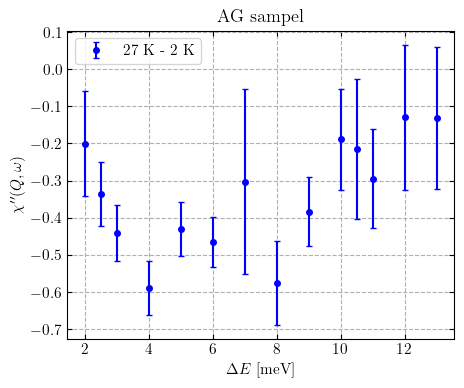

In [57]:
x= np.linspace(1, 14, 100)

plot_formalia('$\Delta E$ [meV]', '$\chi\'\'(Q,\omega)$','AG sampel')
plt.errorbar(ag_mevs_q_2K, ag_q_2K_intensity_per_monitor - ag_q_27K_intensity_per_monitor, capsize = 2, fmt ='o', yerr = np.sqrt(ag_err_q_27K_intensity_per_monitor**2 + ag_err_q_2K_intensity_per_monitor**2), label = '27 K - 2 K ', color = 'b')
plt.legend()
plt.savefig('AG_E_difference.eps', format='eps')

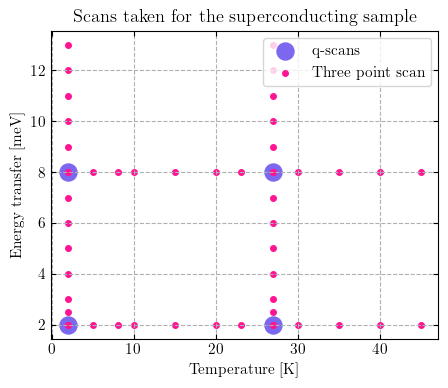

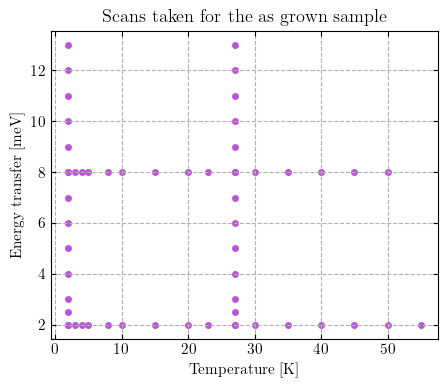

In [58]:
# Plot showing the scans we took

sc_three_temp = np.array([2, 5, 8, 10, 15, 20, 23, 27, 30, 35, 40, 45])
sc_three_2_mev_temp = 2 * np.ones(len(sc_three_temp))
sc_three_8_mev_temp = 8 * np.ones(len(sc_three_temp))
sc_three_27_K_energy = np.array([2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]) 
sc_three_27_K_temp = 27 * np.ones(len(sc_three_27_K_energy))
sc_three_2_K_temp = 2 * np.ones(len(sc_three_27_K_energy))
sc_q_scan_temp = np.array([2, 2, 27, 27])
sc_q_scan_energy = np.array([2, 8, 2, 8])
#print(len(sc_temp))

plot_formalia('Temperature [K]', 'Energy transfer [meV]', 'Scans taken for the superconducting sample')
plt.scatter(sc_q_scan_temp, sc_q_scan_energy, marker = 'o', s = 150, label = 'q-scans', color = 'mediumslateblue')
plt.scatter(sc_three_temp, sc_three_2_mev_temp, label = 'Three point scan', color = 'deeppink')
plt.scatter(sc_three_temp, sc_three_8_mev_temp, color = 'deeppink')
plt.scatter(sc_three_27_K_temp, sc_three_27_K_energy, color = 'deeppink')
plt.scatter(sc_three_2_K_temp, sc_three_27_K_energy, color = 'deeppink')
plt.legend()

ag_2_mev_temp = np.array([2, 3, 4, 5, 8, 10, 15, 20, 23, 27, 30, 35, 40, 45, 50, 55])
ag_8_mev_temp = np.array([2, 3, 4, 5, 8, 10, 15, 20, 23, 27, 30, 35, 40, 45, 50])

ag_2_mev = 2 * np.ones(len(ag_2_mev_temp))
ag_8_mev = 8 * np.ones(len(ag_8_mev_temp))

ag_27_K_energy = np.array([2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ag_27_K = 27 * np.ones(len(ag_27_K_energy))
ag_2_K = 2 * np.ones(len(ag_27_K_energy))

plot_formalia('Temperature [K]', 'Energy transfer [meV]', 'Scans taken for the as grown sample')
plt.scatter(ag_2_mev_temp, ag_2_mev, color = 'mediumorchid')
plt.scatter(ag_8_mev_temp, ag_8_mev, color = 'mediumorchid')
plt.scatter(ag_27_K, ag_27_K_energy, color = 'mediumorchid')
plt.scatter(ag_2_K, ag_27_K_energy, color = 'mediumorchid')





# Article plots

## Raw scans

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


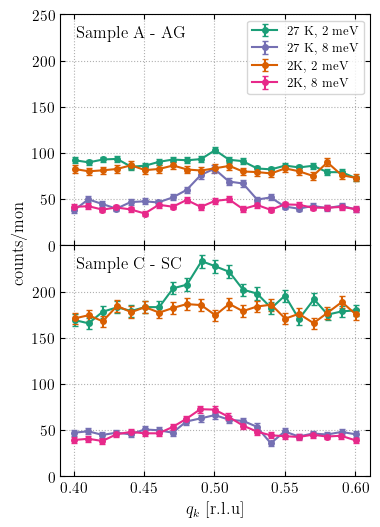

In [59]:
fig, ax = plt.subplots(2,1,figsize=(4,6), sharex=True)
fig.subplots_adjust(hspace=0)

#27 K
ax[0].errorbar(ag_q_27K_2mev[:,2], ag_q_27K_2mev[:,8]/80000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_2mev[:,8])/80000000/ag_phonon_normalisation, fmt = 'o-', label = '27 K, 2 meV')
ax[0].errorbar(ag_q_27K_8mev[:,2], ag_q_27K_8mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_27K_8mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o-', label = '27 K, 8 meV')
# 2 K
ax[0].errorbar(ag_q_2K_2mev[:,2], ag_q_2K_2mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_2mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o-', label = '2K, 2 meV')
ax[0].errorbar(ag_q_2K_8mev[:,2], ag_q_2K_8mev[:,8]/40000000/ag_phonon_normalisation, capsize = 2, yerr = np.sqrt(ag_q_2K_8mev[:,8])/40000000/ag_phonon_normalisation, fmt = 'o-', label = '2K, 8 meV')
ax[0].set_yticks([0, 50, 100, 150, 200, 250])
ax[0].legend(fontsize=9)
ax[0].grid(linestyle='dotted')

#27 K
ax[1].errorbar(sc_q_27K_2mev[:,2], sc_q_27K_2mev[:,8]/120000000/sc_phonon_normalisation, capsize = 2, yerr = np.sqrt(sc_q_27K_2mev[:,8])/120000000/sc_phonon_normalisation, fmt = 'o-', label = '27K, 2 meV')
ax[1].errorbar(sc_q_27K_8mev[:,2], sc_q_27K_8mev[:,8]/120000000/sc_phonon_normalisation, capsize = 2, yerr = np.sqrt(sc_q_27K_8mev[:,8])/120000000/sc_phonon_normalisation, fmt = 'o-', label = '27K, 8 meV')
#2 K
ax[1].errorbar(sc_q_2K_2mev[:,2], sc_q_2K_2mev[:,8]/120000000/sc_phonon_normalisation, capsize = 2, yerr = np.sqrt(sc_q_2K_2mev[:,8])/120000000/sc_phonon_normalisation, fmt = 'o-', label = '2K, 2 meV')
ax[1].errorbar(sc_q_2K_8mev[:,2], sc_q_2K_8mev[:,8]/120000000/sc_phonon_normalisation, capsize = 2, yerr = np.sqrt(sc_q_2K_8mev[:,8])/120000000/sc_phonon_normalisation, fmt = 'o-', label = '2K, 8 meV')


ax[1].set_xlabel('$q_k$ [r.l.u]', fontsize=12)
ax[1].set_yticks([0, 50, 100, 150, 200])
ax[1].set_xticks([0.4, 0.45, 0.5, 0.55, 0.6])
ax[1].grid(linestyle='dotted')
fig.text(0.05, 1.95, 'Sample A - AG', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
fig.text(0.05, 0.95, 'Sample C - SC', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')


plt.ylim(0, 250)
#plt.xlim(0.4,0.6)
fig.text(-0.00, 0.5, 'counts/mon', va='center', rotation='vertical', fontsize=12)
plt.savefig('Raw_scans.eps', format='eps',bbox_inches='tight')

## Energy dependence: Both sampels

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


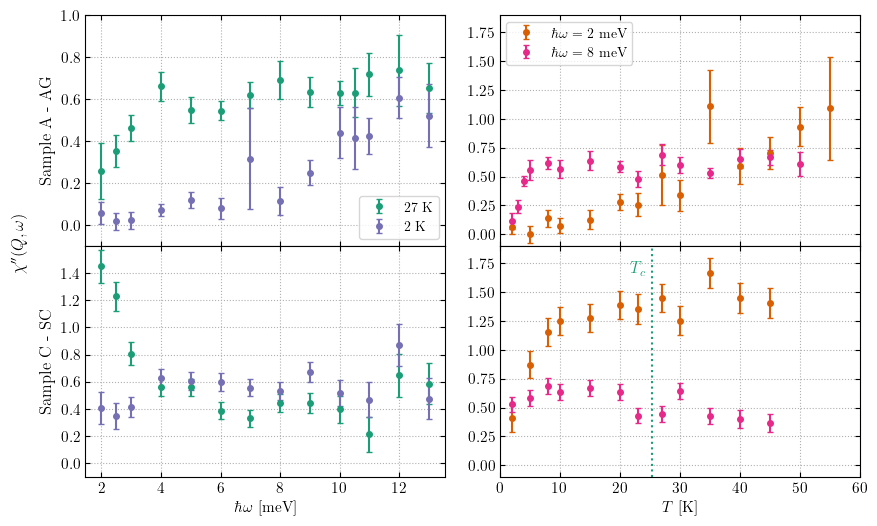

In [60]:
fig, ax = plt.subplots(2,2,figsize=(10,6))
fig.subplots_adjust(hspace=0, wspace=0.15)

ax[0,0].errorbar(ag_mevs_q_27K, ag_q_27K_intensity_per_monitor, capsize = 2, yerr = ag_err_q_27K_intensity_per_monitor, fmt = 'o', label = '27 K')
ax[0,0].errorbar(ag_mevs_q_2K, ag_q_2K_intensity_per_monitor, capsize = 2, yerr = ag_err_q_2K_intensity_per_monitor, fmt = 'o', label = '2 K')
ax[0,0].grid(linestyle='dotted')
ax[0,0].legend(fontsize=10, loc='lower right')
ax[0,0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[0,0].set_ylim(-0.1,1.0)

ax[1,0].errorbar(sc_tre_27K_mevs, sc_tre_27K_intensity, capsize = 2, fmt ='o', yerr = sc_err_tre_27K_intensity, label = '27K')
ax[1,0].errorbar(sc_tre_2K_mevs, sc_tre_2K_intensity, capsize = 2, fmt ='o', yerr = sc_err_tre_2K_intensity, label = '2K')
ax[1,0].grid(linestyle='dotted')
ax[1,0].set_xticks([2, 4, 6, 8, 10, 12])
ax[1,0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
ax[1,0].set_ylim(-0.1,1.6)
ax[0,0].set_xticklabels([])

ax[0,0].set_ylabel('Sample A - AG', fontsize=12)
ax[1,0].set_ylabel('Sample C - SC', fontsize=12)

ax[1,0].set_xlabel('$\hbar \omega$ [meV]')
fig.text(0.05, 0.5, '$\chi\'\'(Q, \omega)$', va='center', rotation='vertical', fontsize=12)

#############################

Tc = np.ones(1000)*25.3

ax[0,1].errorbar(ag_q_temps_2mev, ag_q_2mev_temp_peaks, capsize = 2, yerr = ag_q_err_2mev_temp_peaks, fmt = 'o', label = '$\hbar \omega =$ 2 meV', color= '#d95f02')
ax[0,1].errorbar(ag_q_temps_8mev, ag_q_8mev_temp_peaks, capsize = 2, yerr = ag_q_err_8mev_temp_peaks, fmt = 'o', label = '$\hbar \omega =$ 8 meV', color= '#e7298a')
ax[0,1].grid(linestyle='dotted')
ax[0,1].legend(fontsize=10)
ax[0,1].set_yticks([0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75])
ax[0,1].set_ylim(-0.1, 1.9)
ax[0,1].set_xlim(0, 60)
ax[0,1].set_xticklabels([])
ax[1,1].errorbar(sc_tre_temps, sc_tre_2mev_temp_peaks, capsize = 2, fmt ='o', yerr = sc_err_tre_2mev_temp_peaks, label = '2 meV', color= '#d95f02')
ax[1,1].errorbar(sc_tre_temps, sc_tre_8mev_temp_peaks, capsize = 2, fmt ='o', yerr = sc_err_tre_8mev_temp_peaks, label = '8 meV', color= '#e7298a')
ax[1,1].grid(linestyle='dotted')
ax[1,1].plot(Tc, np.linspace(-0.1, 1.9, 1000),linestyle='dotted')
ax[1,1].set_xlim(0,57)
ax[1,1].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75])
ax[1,1].set_ylim(-0.1, 1.9)
ax[1,1].set_xlim(0, 60)

ax[1,1].set_xlabel('$T$ [K]')

fig.text(0.67, 0.45, '$T_c$', fontsize=12, color='#1b9e77')

plt.savefig('E_and_T_dependence.eps', format='eps',bbox_inches='tight')

## 27 K - 2 K

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


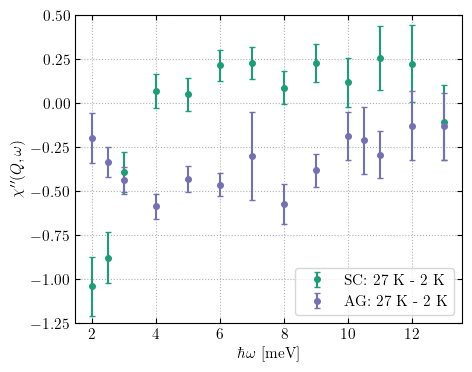

In [61]:
plt.figure(figsize=(5,4))

plt.errorbar(sc_tre_2K_mevs, sc_tre_2K_intensity - sc_tre_27K_intensity, capsize = 2, fmt ='o', yerr = np.sqrt(sc_err_tre_27K_intensity**2 + sc_err_tre_2K_intensity**2), label = 'SC: 27 K - 2 K ')
plt.errorbar(ag_mevs_q_2K, ag_q_2K_intensity_per_monitor - ag_q_27K_intensity_per_monitor, capsize = 2, fmt ='o', yerr = np.sqrt(ag_err_q_27K_intensity_per_monitor**2 + ag_err_q_2K_intensity_per_monitor**2), label = 'AG: 27 K - 2 K ')

plt.ylabel('$\chi\'\'(Q, \omega)$')
plt.xlabel('$\hbar \omega$ [meV]')
plt.yticks([-1.25, -1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5])
plt.ylim(-1.25,0.5)
plt.grid(linestyle='dotted')
plt.legend()

plt.savefig('T_difference.eps', format='eps',bbox_inches='tight')


## Temperature dependence

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


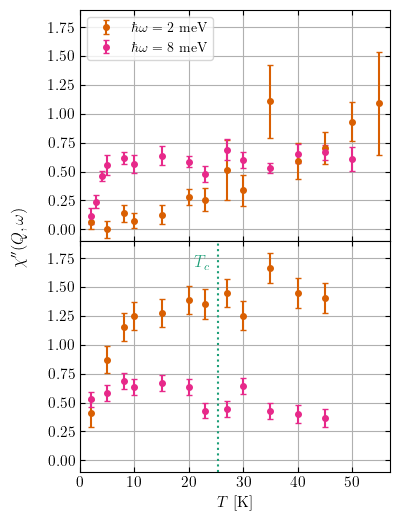

In [62]:
fig, ax = plt.subplots(2,1,figsize=(4,6), sharex=True)
fig.subplots_adjust(hspace=0)

Tc = np.ones(1000)*25.3

ax[0].errorbar(ag_q_temps_2mev, ag_q_2mev_temp_peaks, capsize = 2, yerr = ag_q_err_2mev_temp_peaks, fmt = 'o', label = '$\hbar \omega =$ 2 meV', color= '#d95f02')
ax[0].errorbar(ag_q_temps_8mev, ag_q_8mev_temp_peaks, capsize = 2, yerr = ag_q_err_8mev_temp_peaks, fmt = 'o', label = '$\hbar \omega =$ 8 meV', color= '#e7298a')
ax[0].grid()
ax[0].legend(fontsize=10)
ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75])
ax[0].set_ylim(-0.1, 1.9)

ax[1].errorbar(sc_tre_temps, sc_tre_2mev_temp_peaks, capsize = 2, fmt ='o', yerr = sc_err_tre_2mev_temp_peaks, label = '2 meV', color= '#d95f02')
ax[1].errorbar(sc_tre_temps, sc_tre_8mev_temp_peaks, capsize = 2, fmt ='o', yerr = sc_err_tre_8mev_temp_peaks, label = '8 meV', color= '#e7298a')
ax[1].grid()
ax[1].plot(Tc, np.linspace(-0.1, 1.9, 1000),linestyle='dotted')
ax[1].set_xlim(0,57)
ax[1].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75])
ax[1].set_ylim(-0.1, 1.9)

ax[1].set_xlabel('$T$ [K]')
fig.text(-0.05, 0.5, '$\chi\'\'(Q, \omega)$', va='center', rotation='vertical', fontsize=12)

fig.text(0.41, 0.45, '$T_c$', fontsize=12, color='#1b9e77')

plt.savefig('T_dependence.eps', format='eps',bbox_inches='tight')

# SM Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


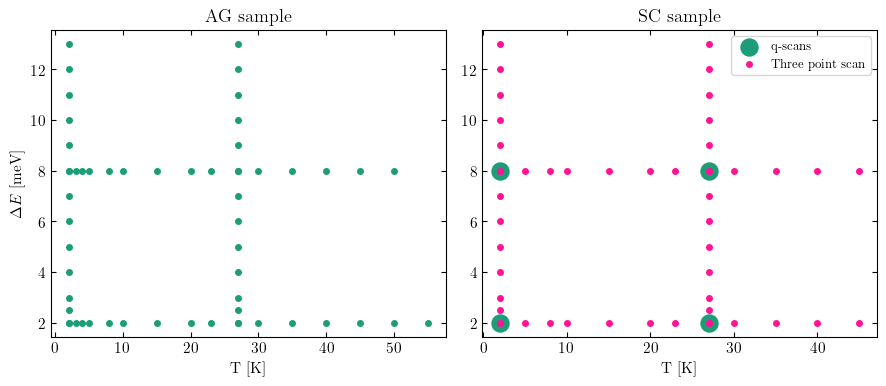

In [63]:
fig, ax = plt.subplots(1,2,figsize=(9,4))

ax[0].scatter(ag_2_mev_temp, ag_2_mev, color = '#1b9e77')
ax[0].scatter(ag_8_mev_temp, ag_8_mev, color = '#1b9e77')
ax[0].scatter(ag_27_K, ag_27_K_energy, color = '#1b9e77')
ax[0].scatter(ag_2_K, ag_27_K_energy, color = '#1b9e77')
ax[0].set_title('AG sample')
ax[0].set_ylabel('$\Delta E$ [meV]')
ax[0].set_xlabel('T [K]')
ax[0].set_xticks([0, 10, 20, 30, 40, 50])


ax[1].scatter(sc_q_scan_temp, sc_q_scan_energy, marker = 'o', s = 150, label = 'q-scans', color = '#1b9e77')
ax[1].scatter(sc_three_temp, sc_three_2_mev_temp, label = 'Three point scan', color = 'deeppink')
ax[1].scatter(sc_three_temp, sc_three_8_mev_temp, color = 'deeppink')
ax[1].scatter(sc_three_27_K_temp, sc_three_27_K_energy, color = 'deeppink')
ax[1].scatter(sc_three_2_K_temp, sc_three_27_K_energy, color = 'deeppink')
ax[1].set_title('SC sample')
ax[1].set_xlabel('T [K]')
ax[1].legend(fontsize=9)
fig.tight_layout()
plt.savefig('Measuring_space.eps', format='eps', )

# Suseptibility

In [64]:
#Susceptibility
ag_susceptibility = np.genfromtxt('./Suscep_data/20240222_NCCO_AG.dc.dat', delimiter = ',', skip_header = 31)
ag_suscep_temperature = ag_susceptibility[:,3]
ag_suscep_long_moment = ag_susceptibility[:,4]

sc_susceptibility = np.genfromtxt('./Suscep_data/20240223_NCCO_SC_Canada4_full_size.dc.dat', delimiter = ',', skip_header = 31)
sc_suscep_temperature = sc_susceptibility[:,3]
sc_suscep_long_moment = sc_susceptibility[:,4]


FileNotFoundError: ./Suscep_data/20240222_NCCO_AG.dc.dat not found.

In [ ]:
plot_formalia('Temperature [K]', 'Long Moment [emu]', 'Susceptibility') 
plt.scatter(ag_suscep_temperature, ag_suscep_long_moment, label = 'As grown sample', color = 'mediumslateblue')
plt.scatter(sc_suscep_temperature[0:97], sc_suscep_long_moment[0:97], label = 'Superconducting sample', color = 'deeppink')
plt.legend()
